In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#from collections import defaultdict

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
# step backward feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [3]:
df_train = pd.read_csv('data/train.csv')
df_val = pd.read_csv('data/test.csv')
df_out = df_val[['Id']]

print(df_train.shape)
print(df_val.shape)

(137, 43)
(100000, 42)


In [4]:
#data frame for summarizing
metrics = pd.DataFrame(columns=['model', 'encoder', 'features', 'test rmse', 'test r2', 'private score', 'public score'])

### 1. PREPROC + EDA

In [5]:
df_train.head(5)

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [6]:
### save results in .pdf file 
plt.style.use('seaborn')
pdf = matplotlib.backends.backend_pdf.PdfPages("linear.pdf")

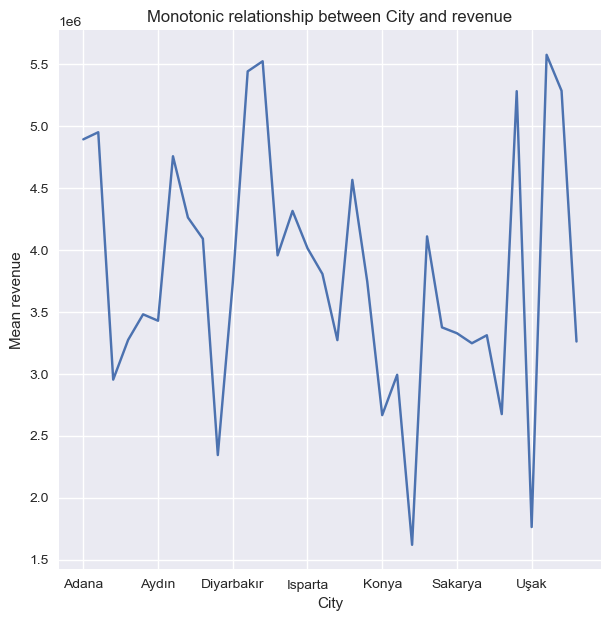

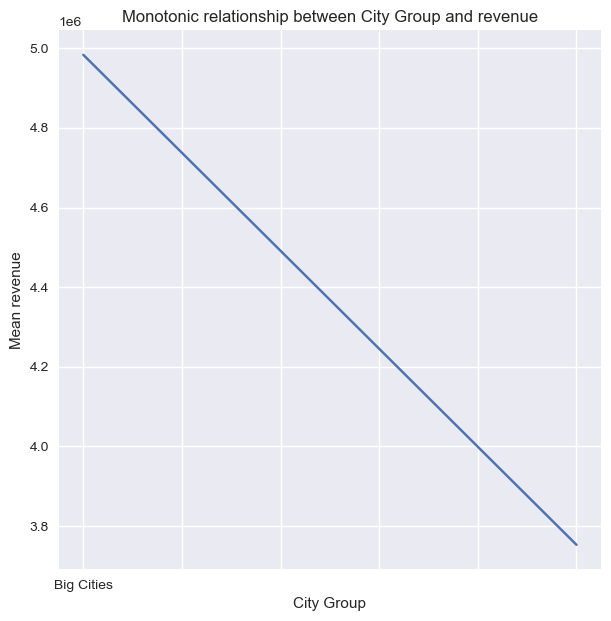

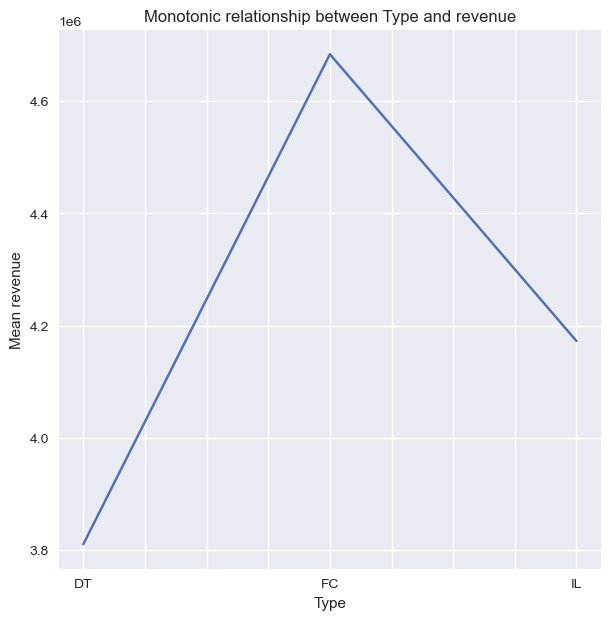

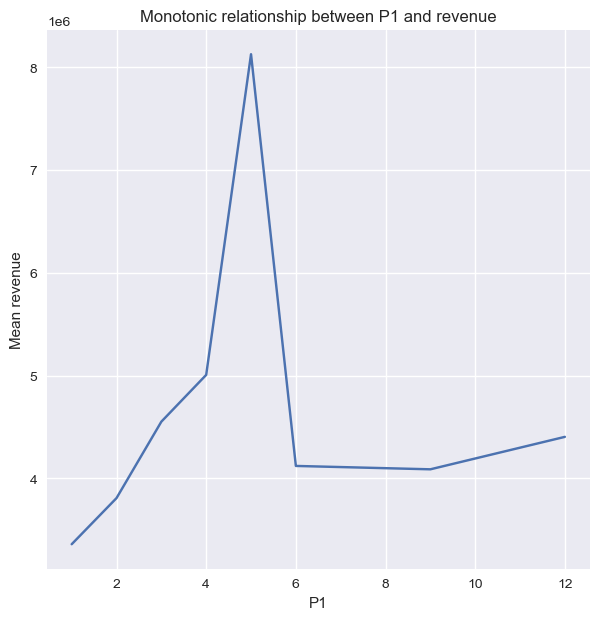

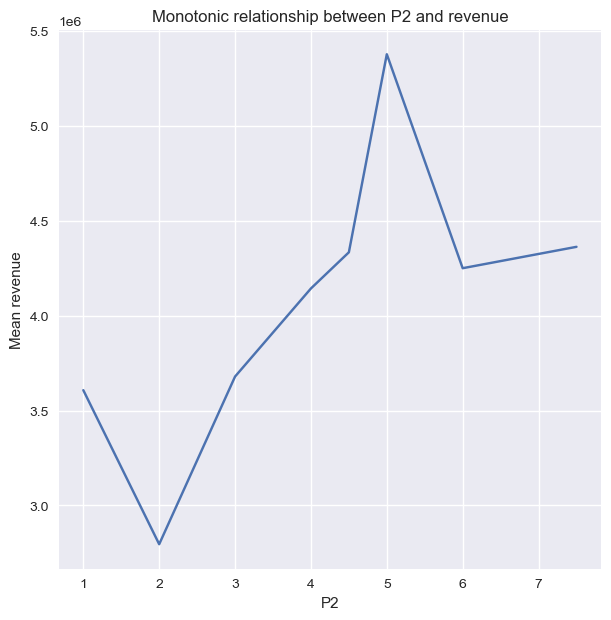

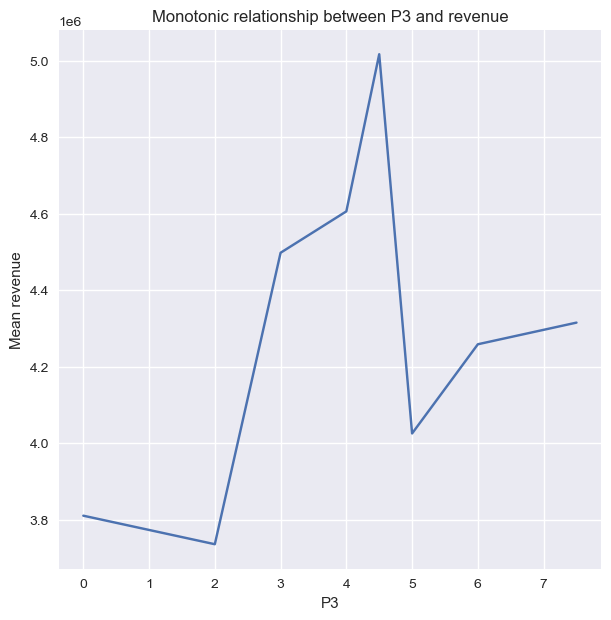

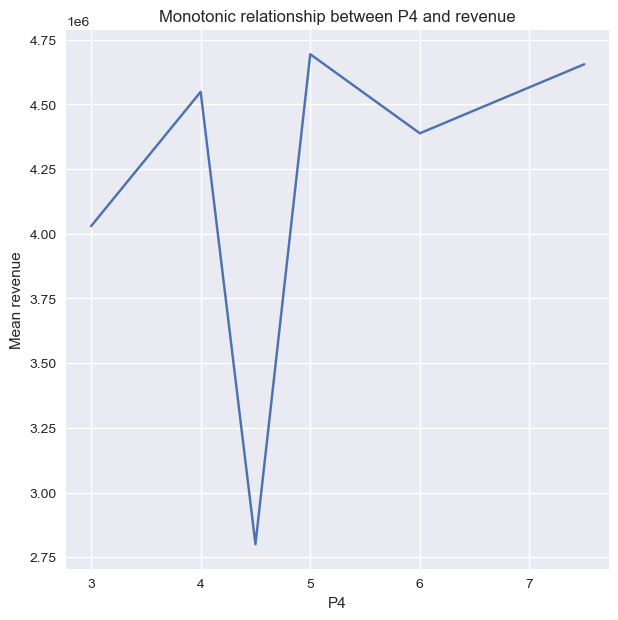

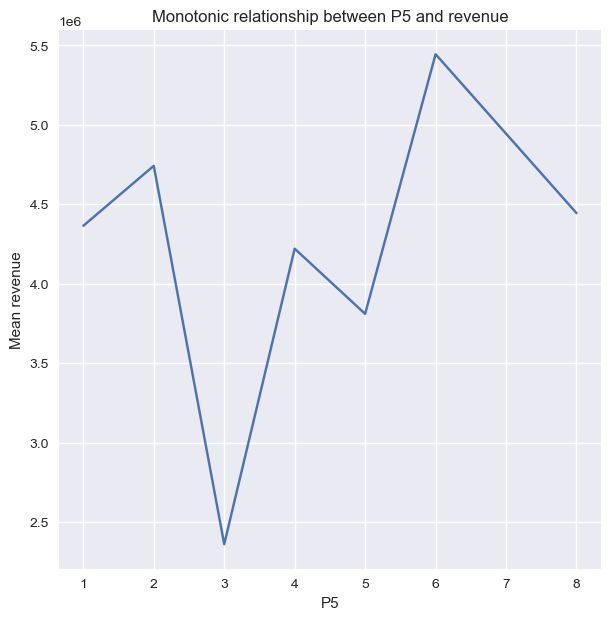

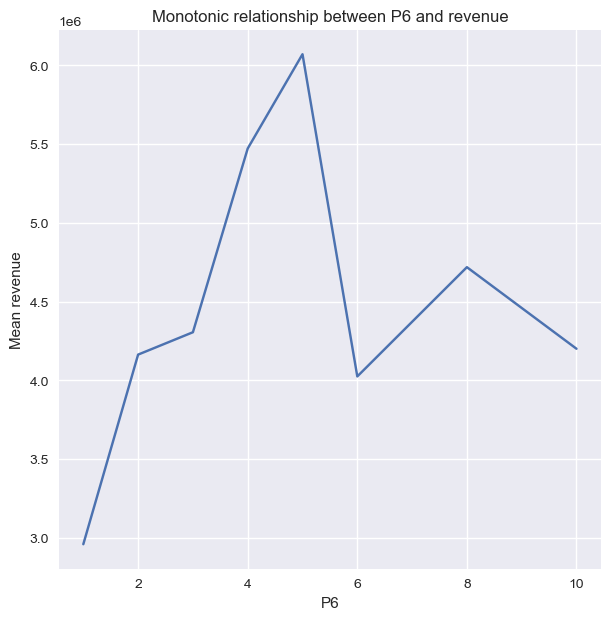

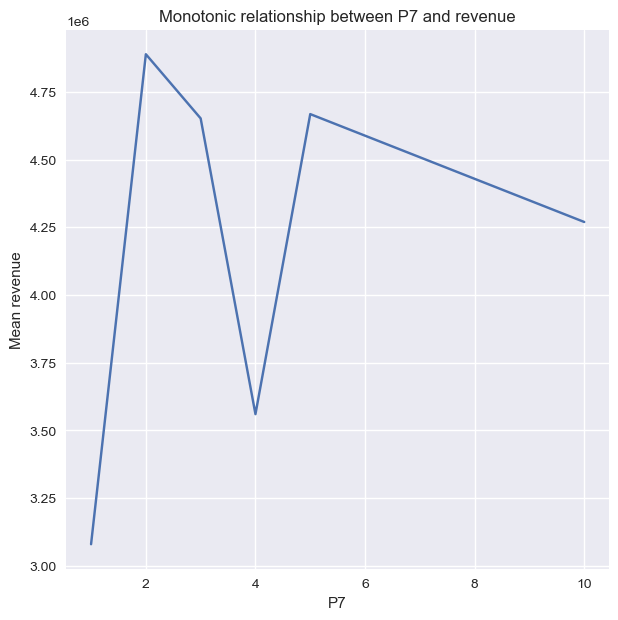

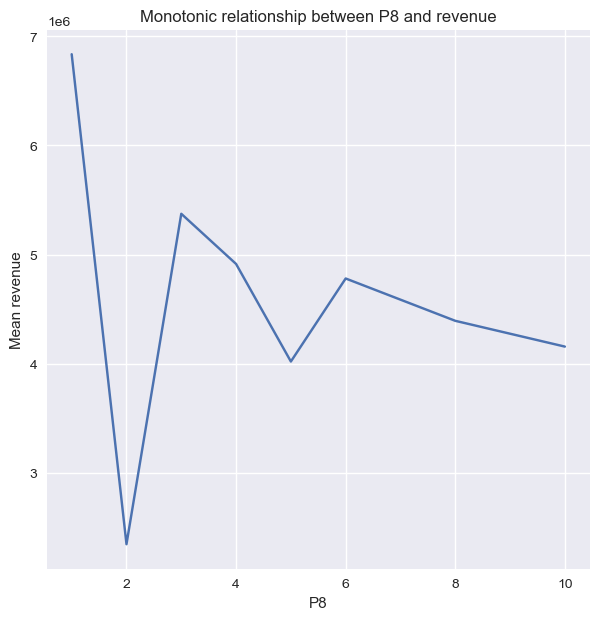

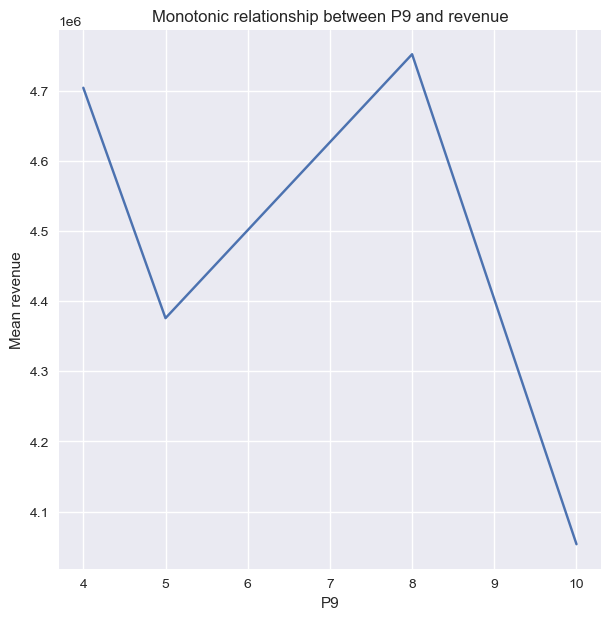

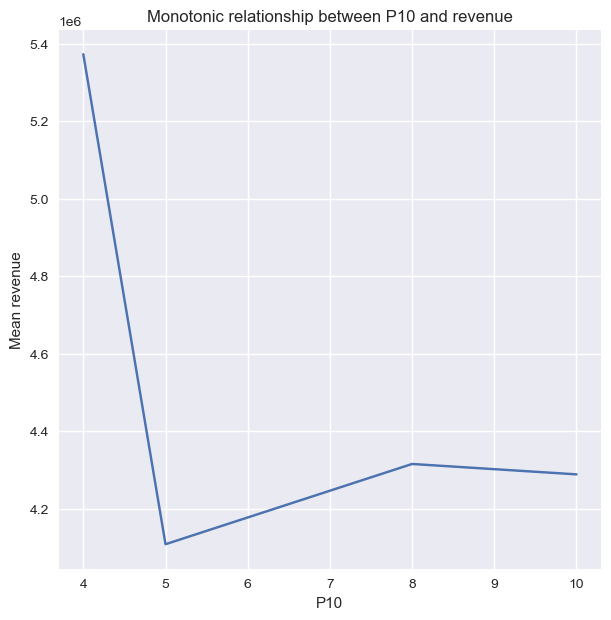

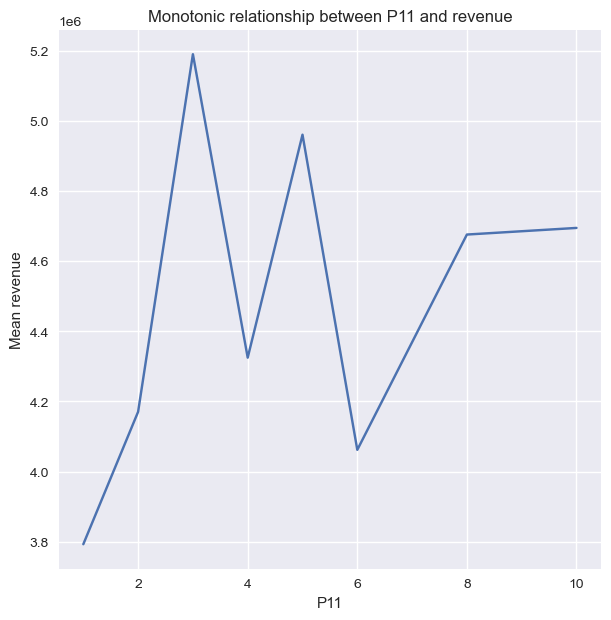

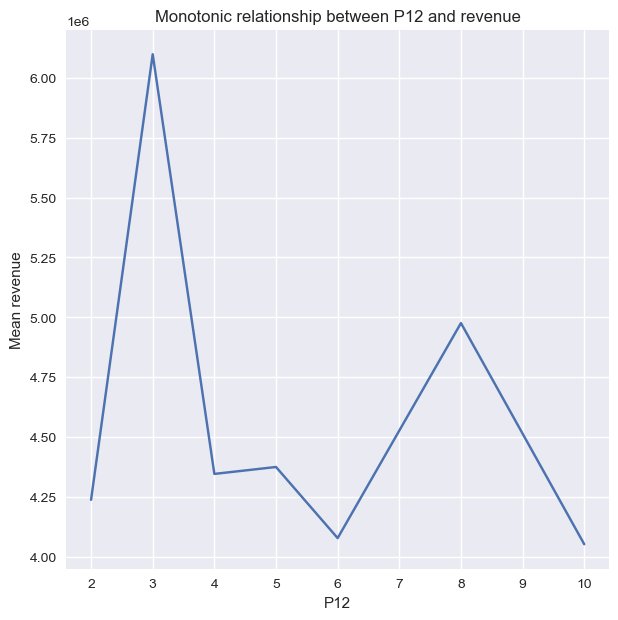

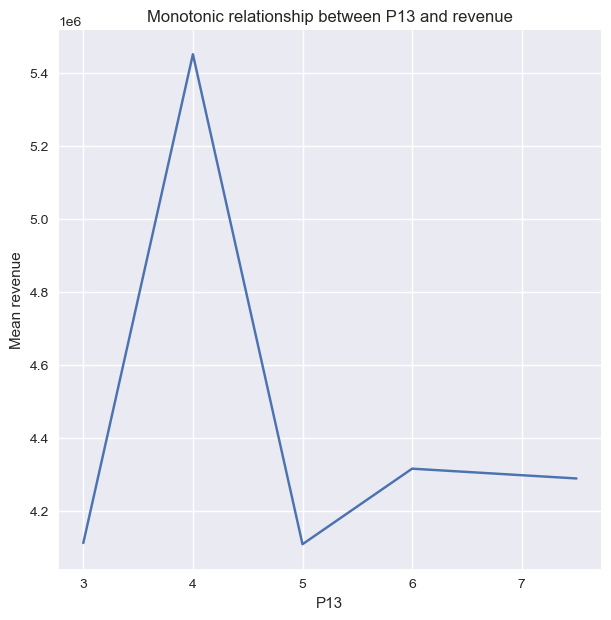

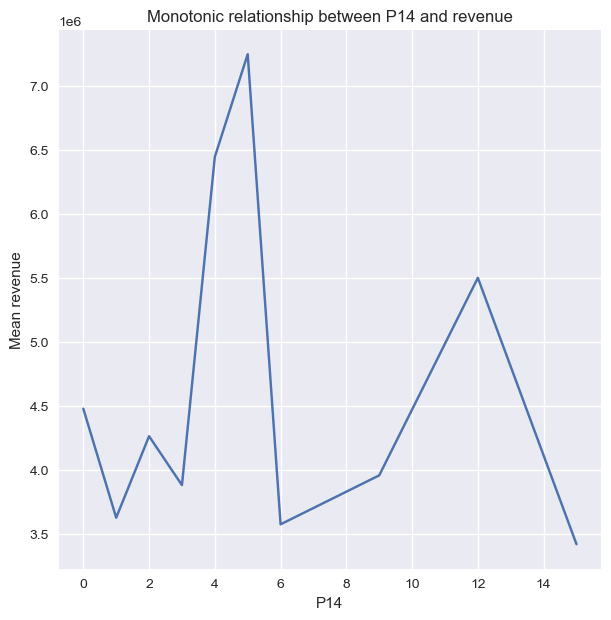

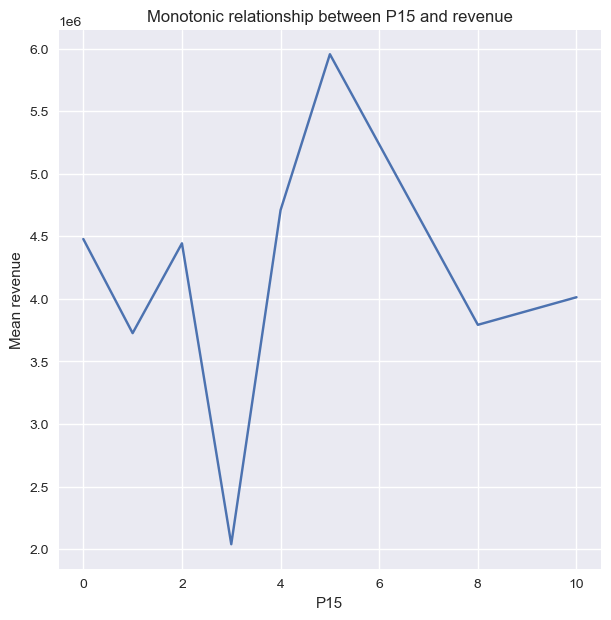

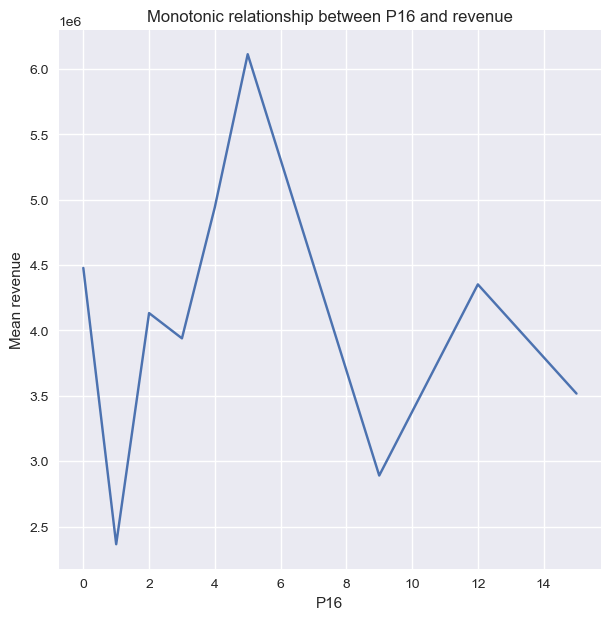

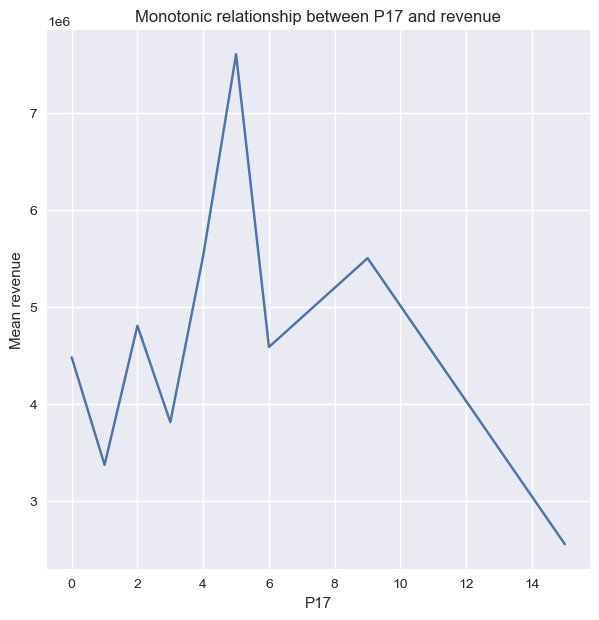

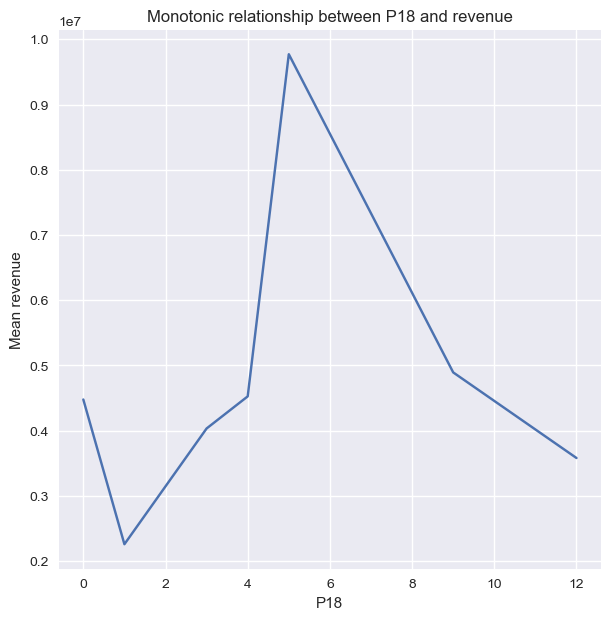

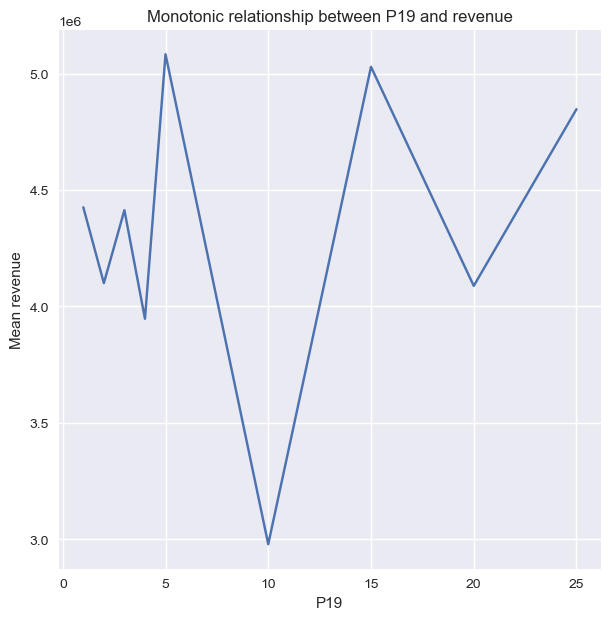

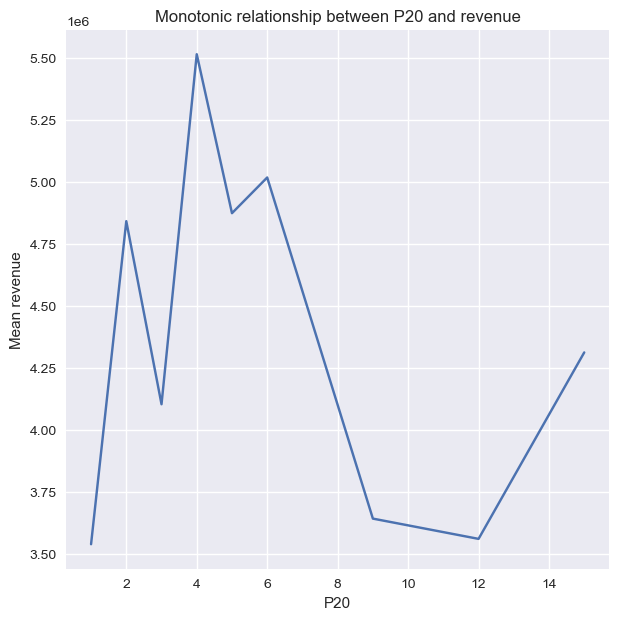

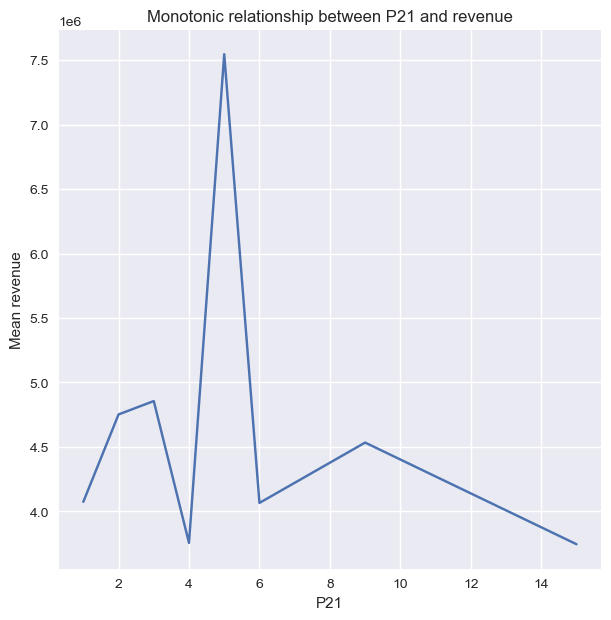

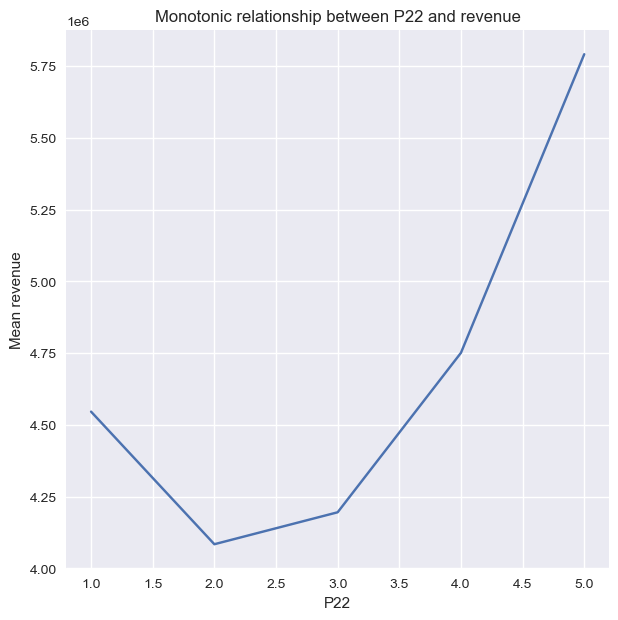

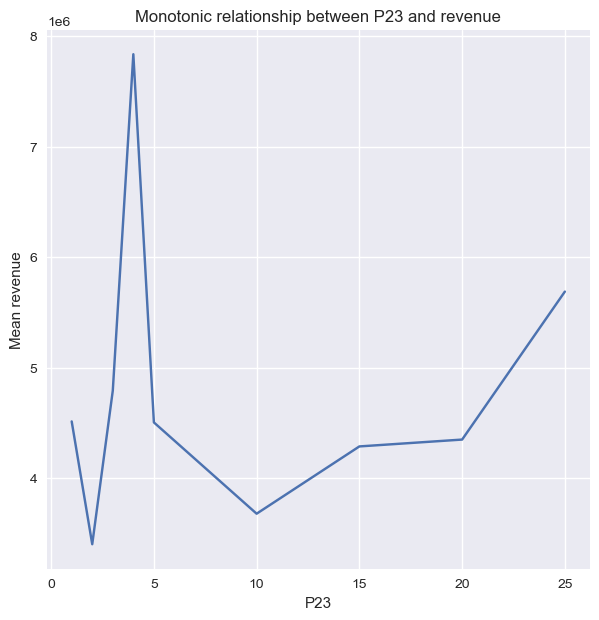

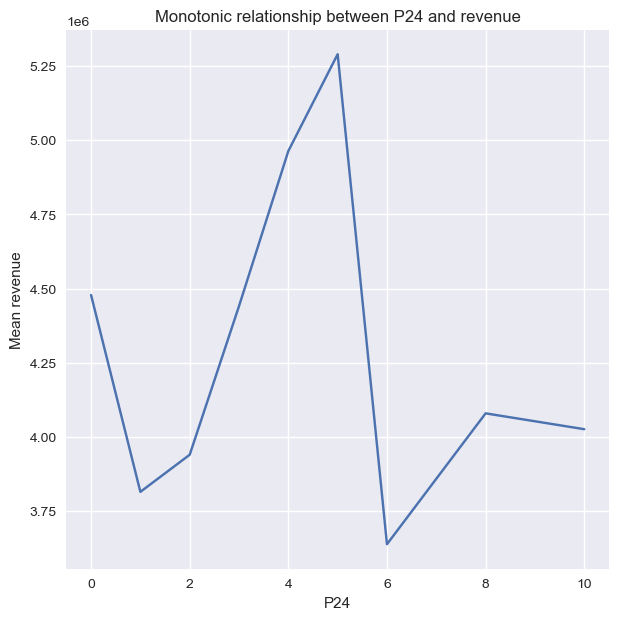

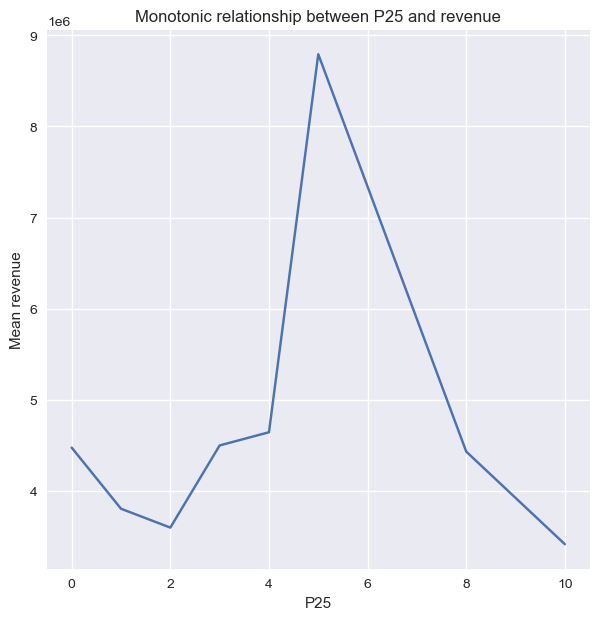

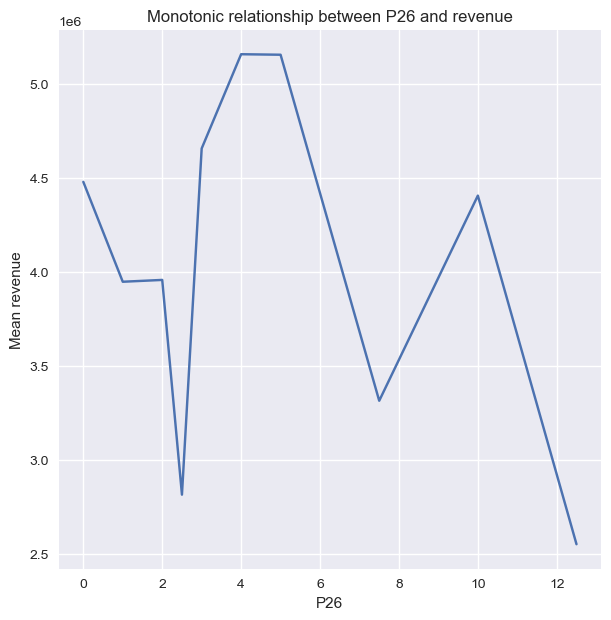

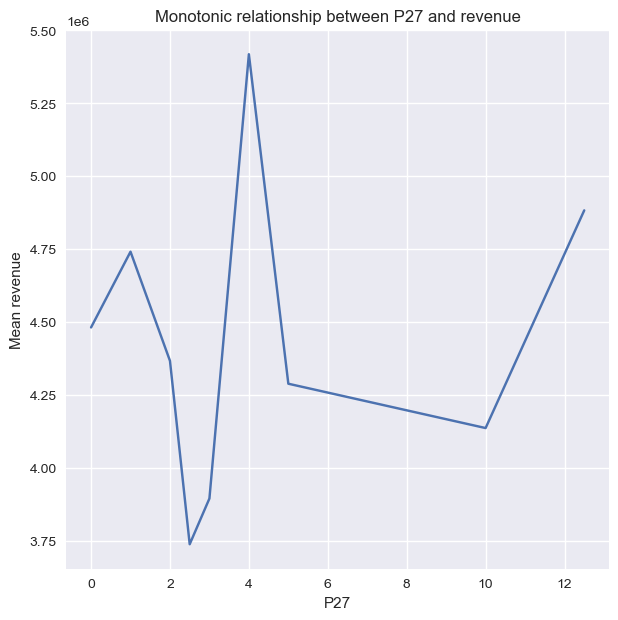

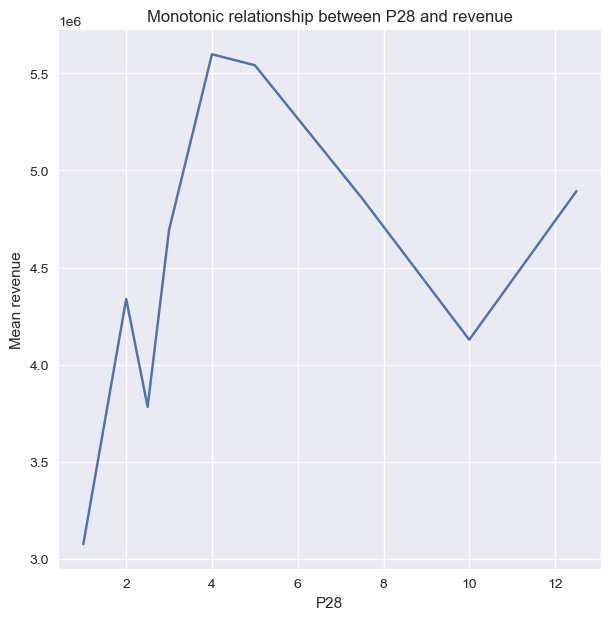

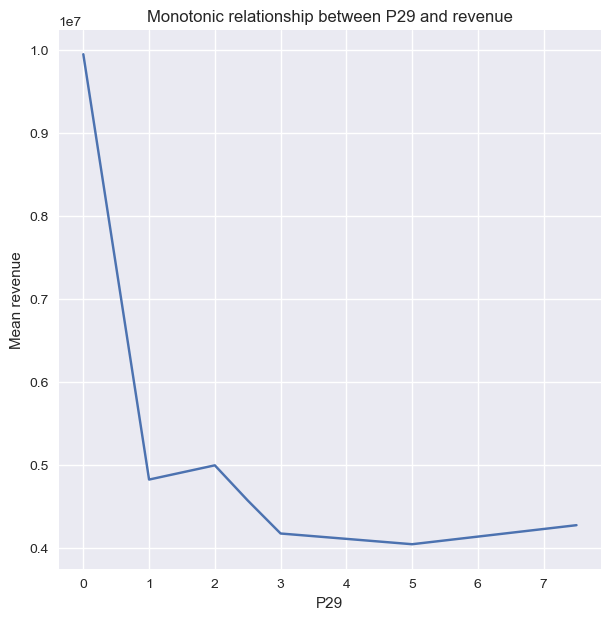

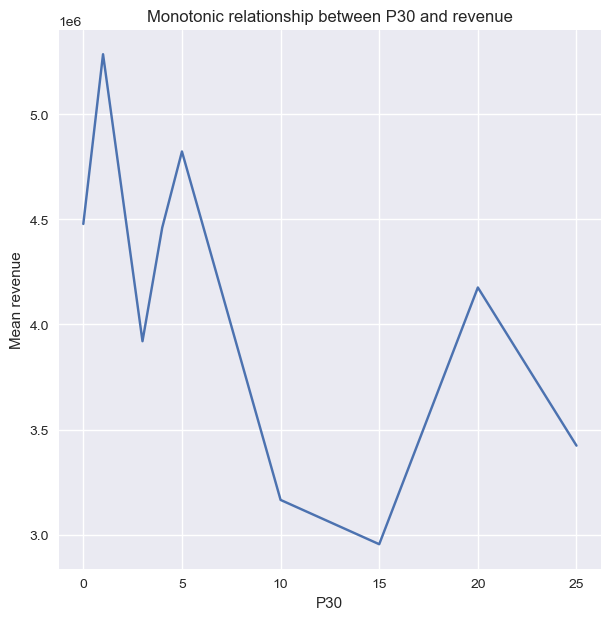

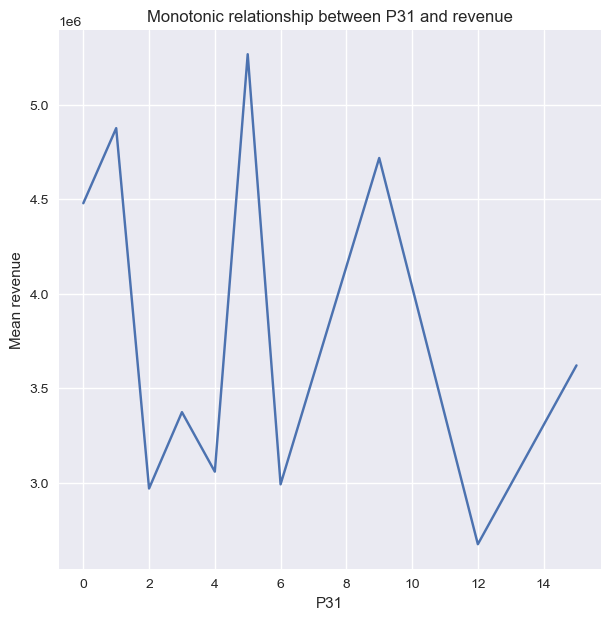

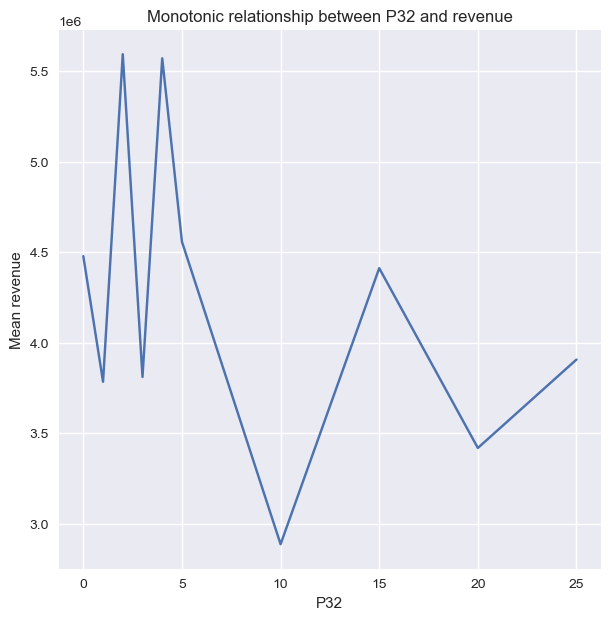

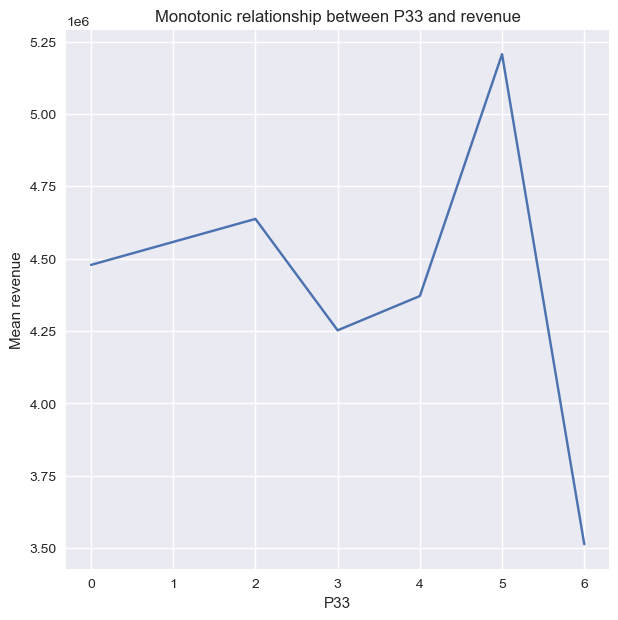

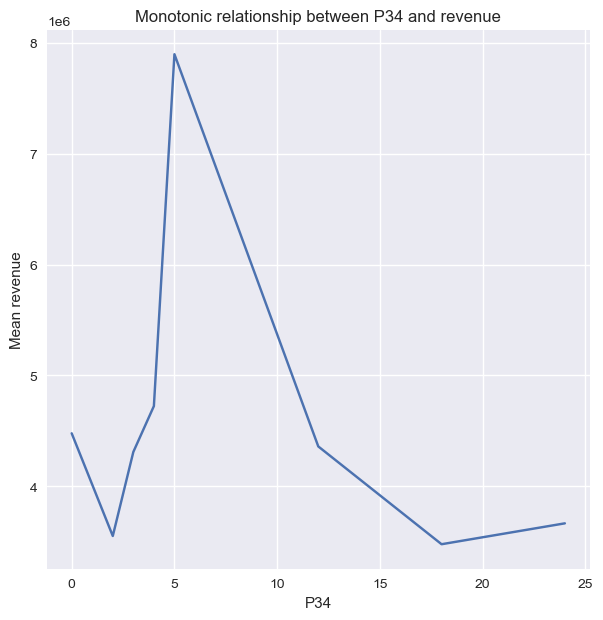

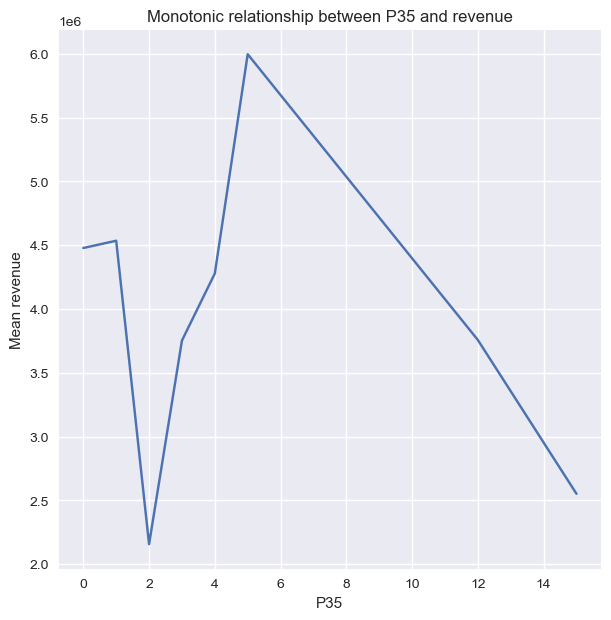

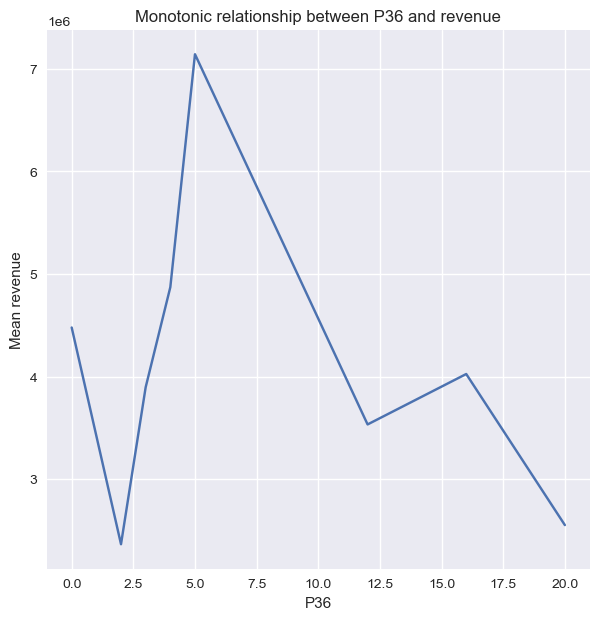

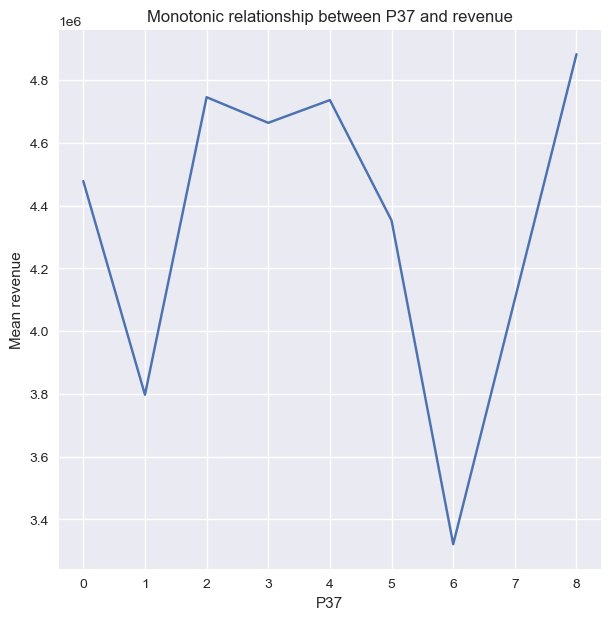

In [7]:
for col in df_train.columns[2:-1]:    
    fig = plt.figure(figsize=(7,7))
    fig = df_train.groupby([col])['revenue'].mean().plot()
    fig.set_title(f'Monotonic relationship between {col} and revenue')
    fig.set_ylabel('Mean revenue')
    plt.show()
pdf.close()    

We can see that the relationship between the target and the categories of the categorical variables goes up and down, depending on the category.

In [8]:
## A function for days counting
own_date = date(2015, 1, 1) ### This competition ended in 2015 
def transform_date(df, new_date):
    df[['Open Date']] = df[['Open Date']].apply(pd.to_datetime)
    df['open_days'] = (pd.Timestamp(new_date) - df['Open Date']).dt.days
    df.drop(['Open Date'], axis=1, inplace=True)
    return df

In [9]:
df_train = transform_date(df_train, own_date)
df_val = transform_date(df_val, own_date)

In [10]:
df_train.drop(['Id'], axis=1, inplace=True)
df_val.drop(['Id'], axis=1, inplace=True)

### 2. Train and test split

In [11]:
percentage = 15
bounder = int(np.floor(len(df_train)*percentage/100))

In [12]:
X_train = df_train.iloc[bounder:, :]
X_test = df_train.iloc[:bounder, :]

X_train.shape, X_test.shape

((117, 42), (20, 42))

In [13]:
### choose only P features
X_train.iloc[:, 3:-2].head(5)

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
20,3,4.0,4.0,4.0,2,2,5,4,5,5,...,1.0,3.0,5,1,2,2,4,5,5,4
21,5,5.0,4.0,4.0,2,2,5,4,4,4,...,3.0,1.0,0,0,0,0,0,0,0,0
22,9,6.0,6.0,6.0,4,6,10,10,10,10,...,7.5,7.5,0,0,0,0,0,0,0,0
23,2,4.0,4.0,4.0,2,2,5,3,4,4,...,2.0,3.0,0,0,0,0,0,0,0,0
24,5,5.0,3.0,5.0,2,2,5,5,5,4,...,3.0,2.0,5,5,4,4,4,4,5,2


In [14]:
regressor = LinearRegression(fit_intercept = True)
regressor.fit(X_train.iloc[:, 3:-2], X_train.revenue)

LinearRegression()

In [15]:
y_pred = regressor.predict(X_test.iloc[:, 3:-2])
print(f'RMSE: {mean_squared_error(X_test.revenue, y_pred, squared=False):.2f}')
print(f'R2: {r2_score(X_test.revenue, y_pred):.4f}')

RMSE: 5511194.79
R2: -1.1805


In [16]:
y_val = regressor.predict(df_val.iloc[:, 3:-1])

In [17]:
df_val_out = df_out.copy()
df_val_out.insert(1, "Prediction", y_val, True)

In [18]:
df_val_out['Prediction'] = np.where(df_val_out['Prediction']<0, 0, df_val_out['Prediction'])
df_val_out.to_csv("lin_regression_P.csv", index=False)
## Score: 2938337.32737
## Private score: 2890660.29258

In [19]:
metrics = pd.DataFrame(columns=['model', 'encoder', 'features', 'test rmse', 'test r2', 'private score', 'public score'])

In [20]:
metrics = metrics.append({
                            'model': 'LinearRegression',
                            'encoder': 'no preproc', 
                            'features': 'P1 - P37',
                            'test rmse': mean_squared_error(X_test.revenue, y_pred, squared=False),
                            'test r2': r2_score(X_test.revenue, y_pred), 
                            'private score': 2890660.29258,
                            'public score': 2938337.32737,
                         },
                               ignore_index=True
                        )

C:\Users\Me\AppData\Local\Temp\ipykernel_23004\650317536.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


### 3. Correlation

<AxesSubplot:>

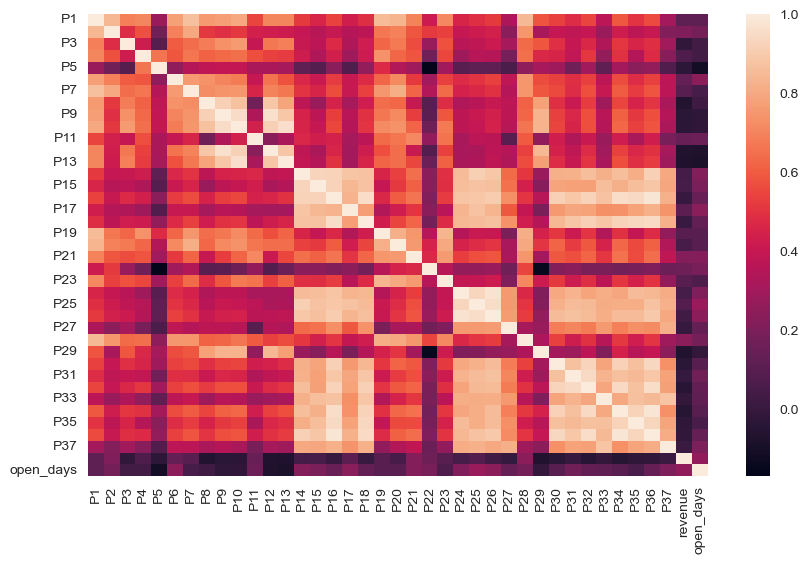

In [21]:
plt.figure(figsize=(10,6))
sns.heatmap(X_train.corr(),annot=False, annot_kws={"size":8})
#sns.set(font_scale = .7)

My idea is to delete features with a very high correlation at this step. We can't explain physical meaning of P features, but I'll trust the math :) Looks like some P features were continius variables, then they were descretisized and encode. Also, some of them looks like a logical blocks with a simular physical meaning.  

In [22]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns    
    corr_matrix = dataset.corr()    
    for i in range(len(corr_matrix.columns)):    
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [23]:
corr_features = correlation(X_train, 0.9)
print('correlated features: ', len(set(corr_features)) )

correlated features:  14


In [24]:
X_train_selected = X_train.drop(labels=corr_features, axis=1)
X_test_selected = X_test.drop(labels=corr_features, axis=1)

print('New shapes:')
X_train_selected.shape, X_test_selected.shape

New shapes:


((117, 28), (20, 28))

In [25]:
y_train = X_train_selected.pop('revenue')
y_test = X_test_selected.pop('revenue')

In [26]:
columns_selected = X_train_selected.columns[3:].to_list()

In [27]:
regressor = LinearRegression(fit_intercept = True)
regressor.fit(X_train_selected[columns_selected], y_train)

LinearRegression()

In [28]:
y_pred = regressor.predict(X_test_selected[columns_selected])
print(f'RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}')
print(f'R2: {r2_score(y_test, y_pred):.4f}')

RMSE: 4210301.91
R2: -0.2726


In [29]:
y_val = regressor.predict(df_val[columns_selected])

In [30]:
df_val_out = df_out.copy()
df_val_out.insert(1, "Prediction", y_val, True)

In [31]:
df_val_out['Prediction'] = np.where(df_val_out['Prediction']<0, 0, df_val_out['Prediction'])
df_val_out.to_csv("lin_reg_no_corr.csv", index=False)
### Score: 2206471.72576
### Private score: 2460886.50276

In [32]:
metrics = metrics.append({
                            'model': 'LinearRegression',
                            'encoder': 'no corr features', 
                            'features': columns_selected,
                            'test rmse': mean_squared_error(X_test.revenue, y_pred, squared=False),
                            'test r2': r2_score(X_test.revenue, y_pred), 
                            'private score': 2460886.50276,
                            'public score': 2206471.72576,
                         },
                               ignore_index=True
                        )

C:\Users\Me\AppData\Local\Temp\ipykernel_23004\3664167420.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


### 4. Ordered Integer encoding

### Advantages

- quick
- returns pandas dataframe

### Limitations of pandas:

- it does not preserve information from train data to propagate to test data

We need to store the encoding maps separately if planing to use them in production.

In [33]:
X_train_selected = X_train.drop(labels=corr_features, axis=1)
X_test_selected = X_test.drop(labels=corr_features, axis=1)
df_val_encod = df_val.copy()

X_train_selected.shape, X_test_selected.shape

((117, 28), (20, 28))

In [34]:
columns_selected = X_train_selected.columns.to_list()

In [35]:
def find_category_mappings(df, variable, target):
    # first  we generate an ordered list with the labels
    ordered_labels = df.groupby([variable])[target].mean().sort_values().index
    # return the dictionary with mappings
    return {k: i for i, k in enumerate(ordered_labels, 0)}


def integer_encode(train, test, val, variable, ordinal_mapping):
    train[variable] = train[variable].map(ordinal_mapping)
    test[variable] = test[variable].map(ordinal_mapping)
    val[variable] = val[variable].map(ordinal_mapping)

In [36]:
cat_features = ['City', 'City Group', 'Type', 
                'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P11', 'P14', 'P17', 'P19', 
                'P20', 'P21', 'P22', 'P23', 'P24', 'P27', 'P28', 'P29', 'P31', 'P33', 'P37']

In [37]:
for feature in cat_features:
    mappings = find_category_mappings(X_train_selected, feature, 'revenue')
    integer_encode(X_train_selected, X_test_selected, df_val_encod, feature, mappings)

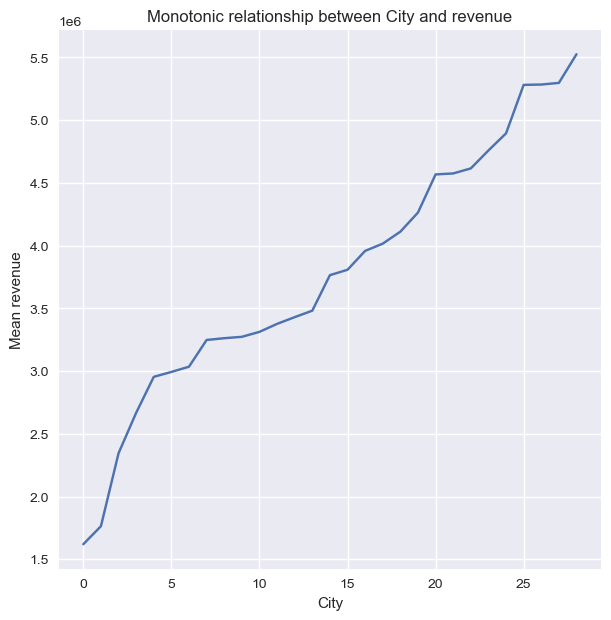

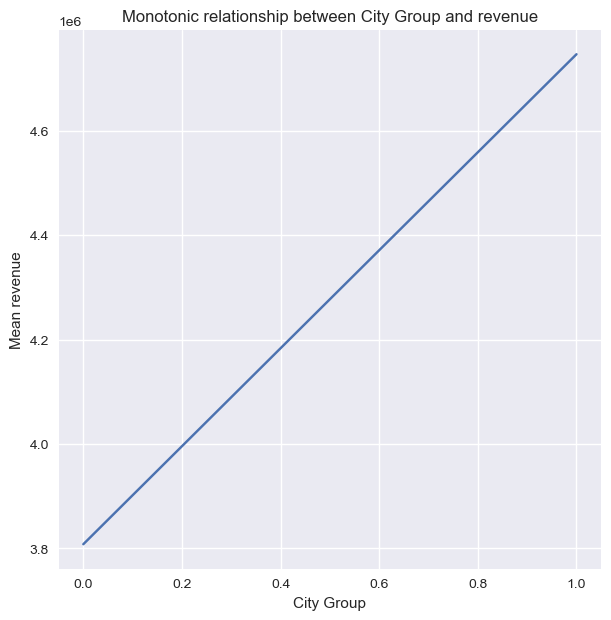

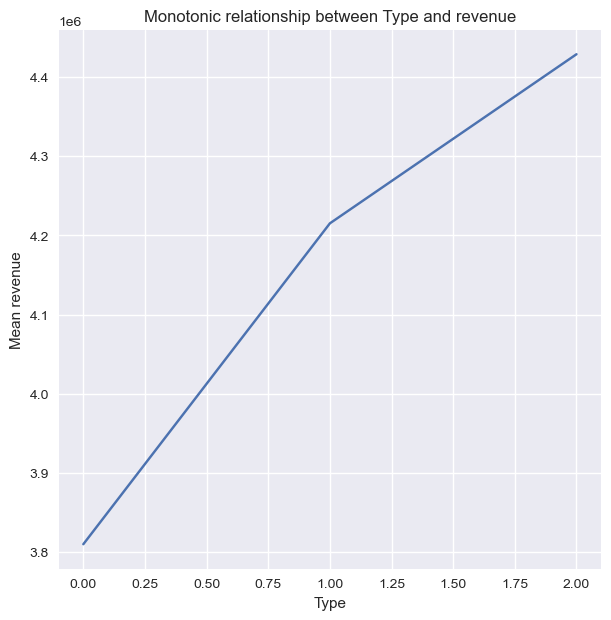

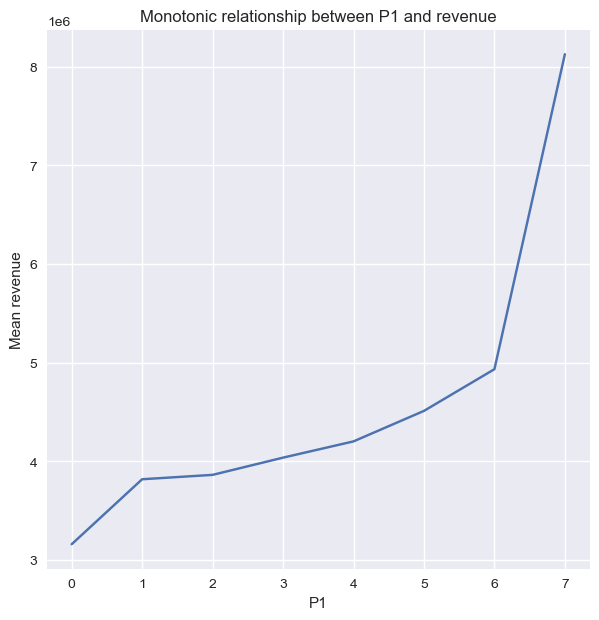

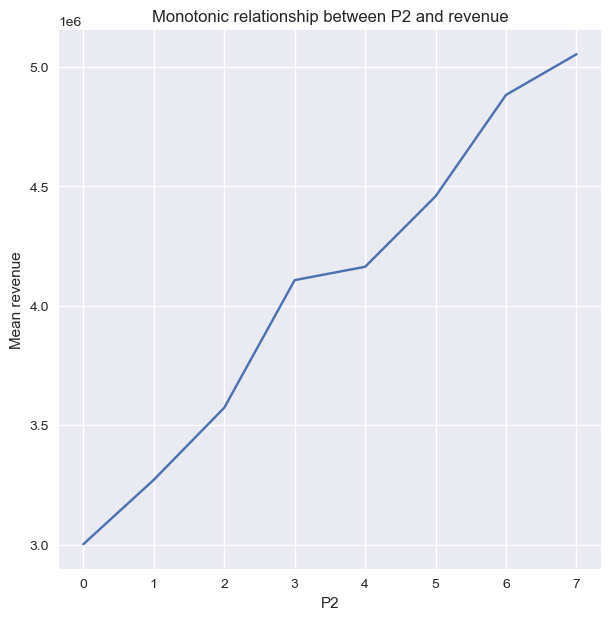

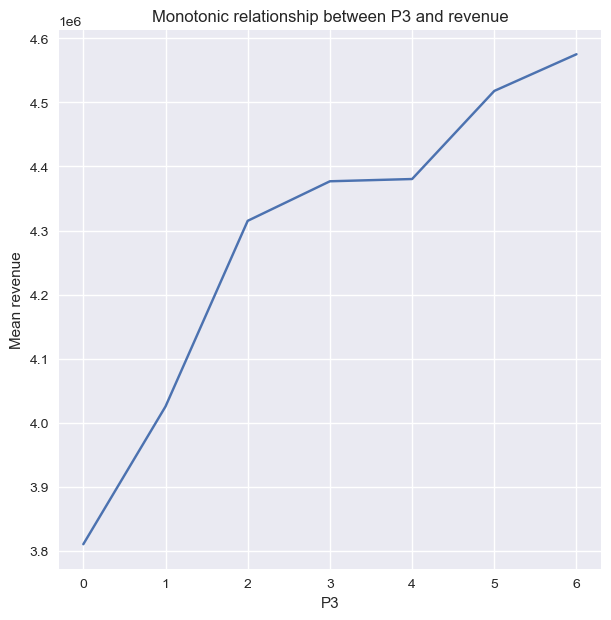

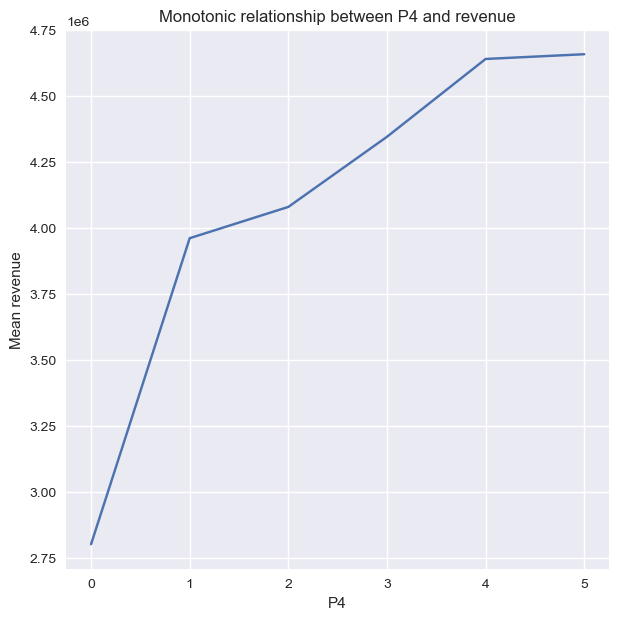

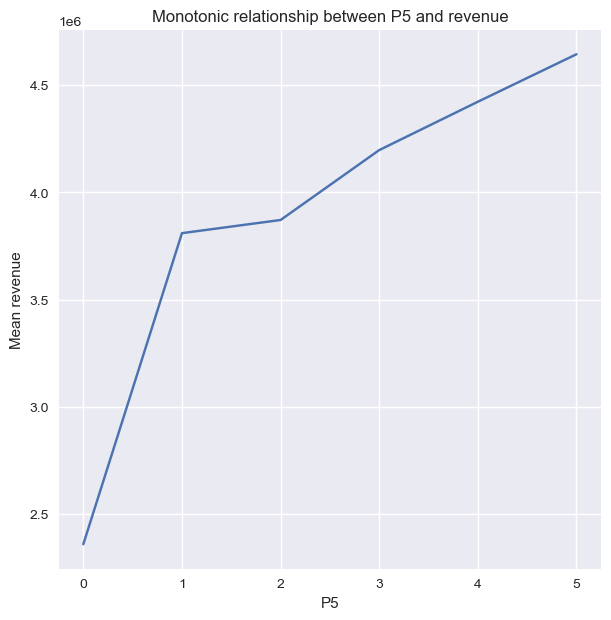

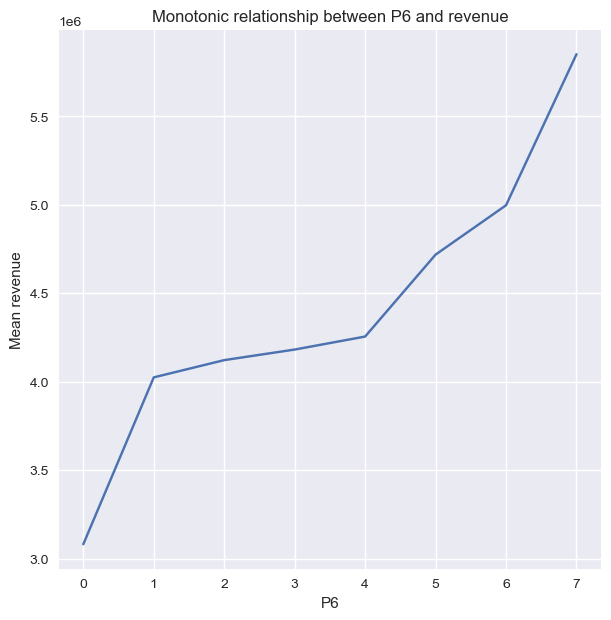

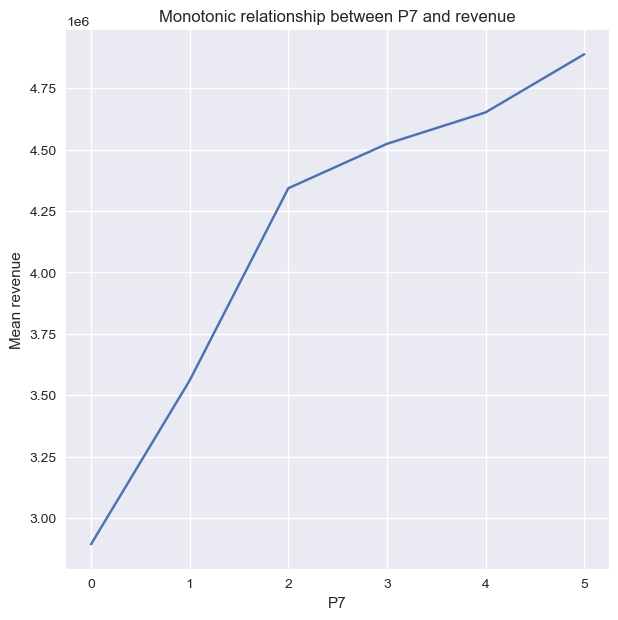

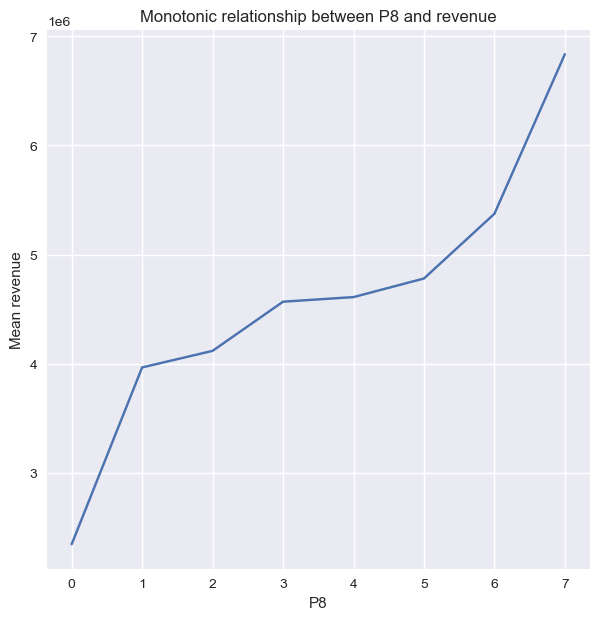

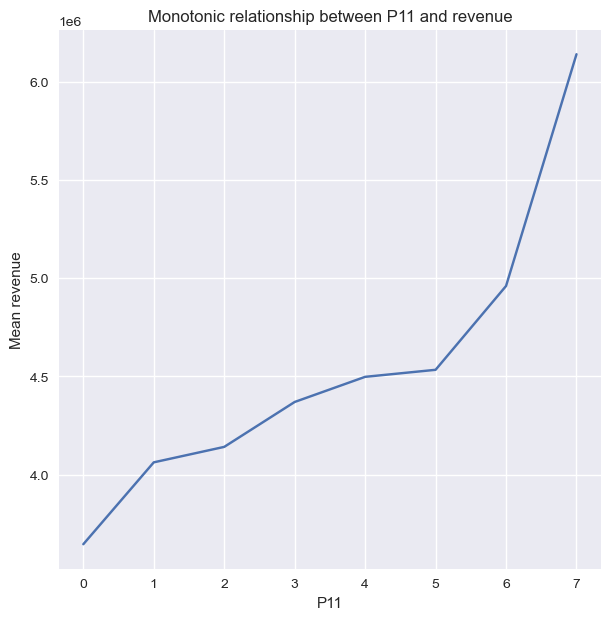

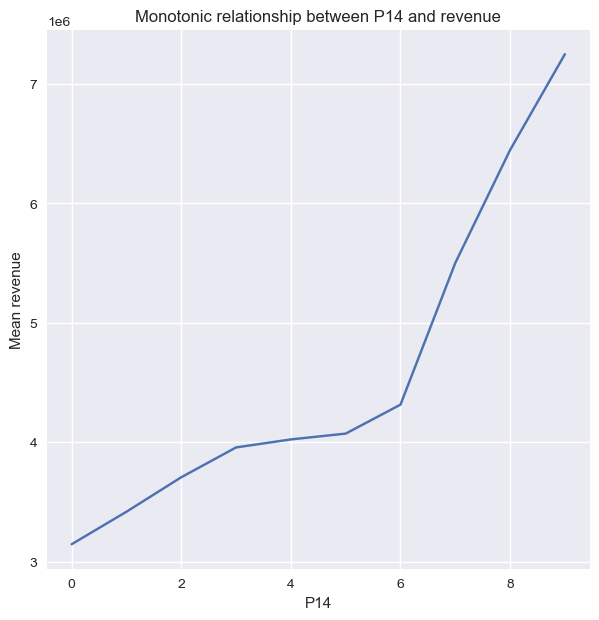

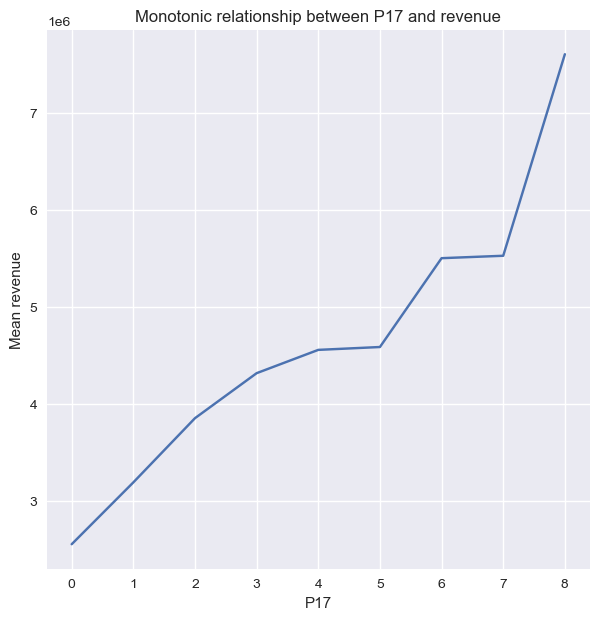

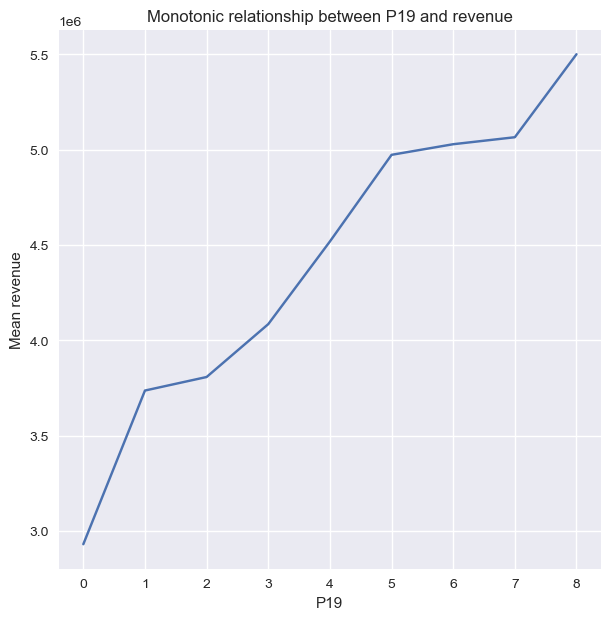

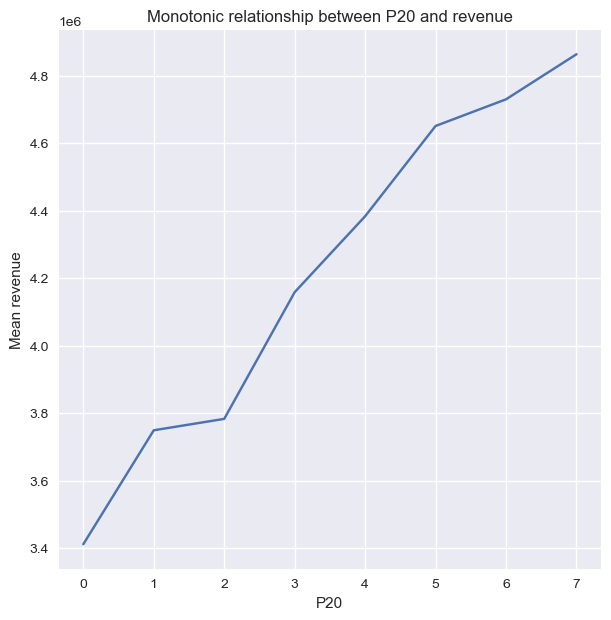

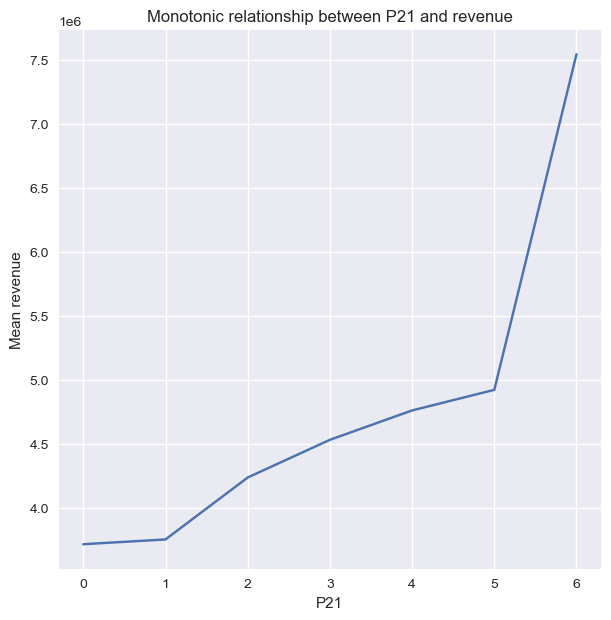

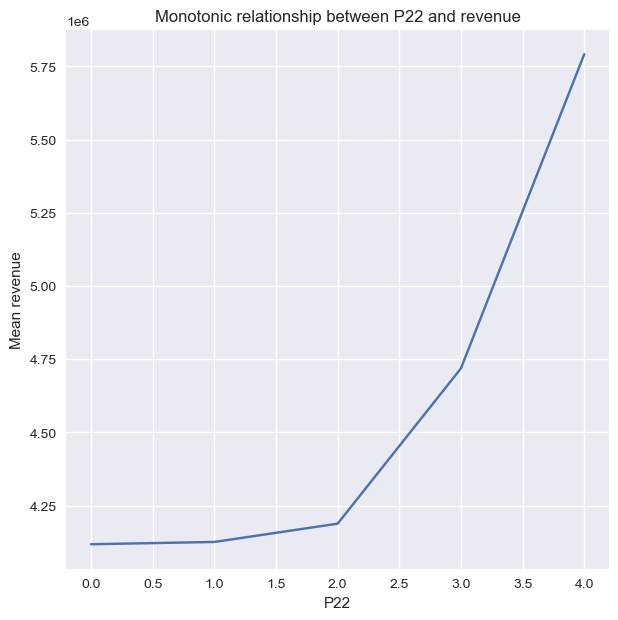

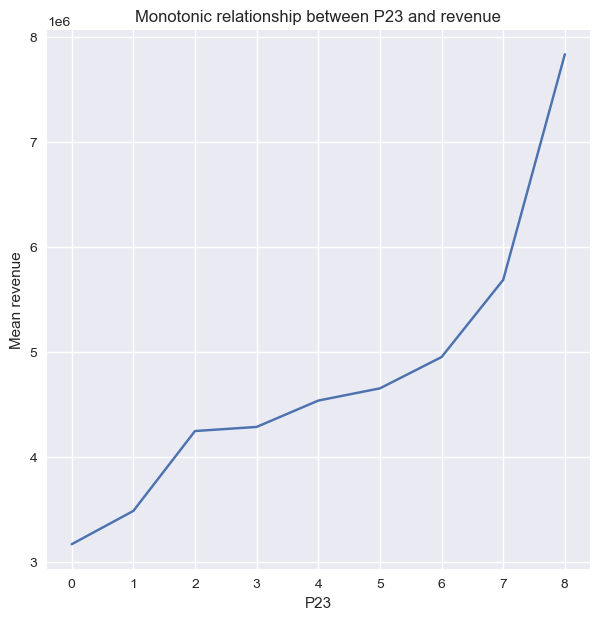

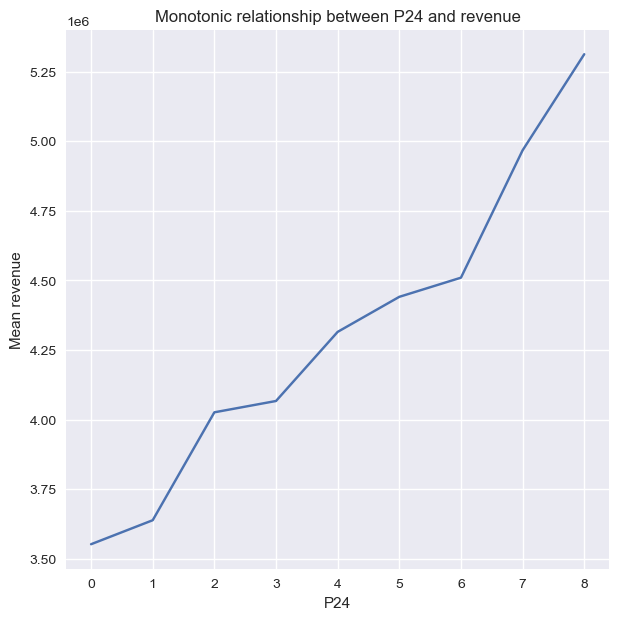

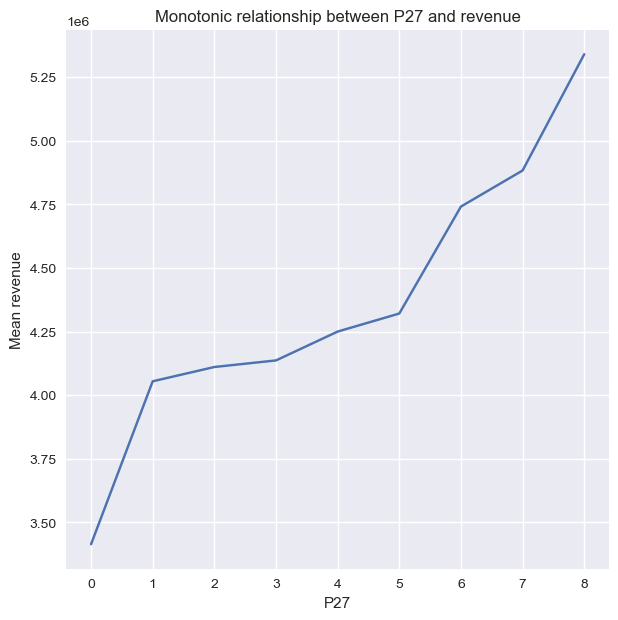

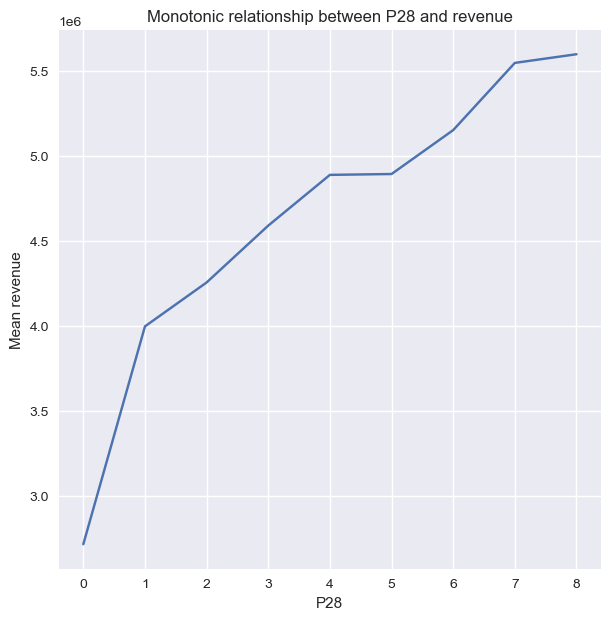

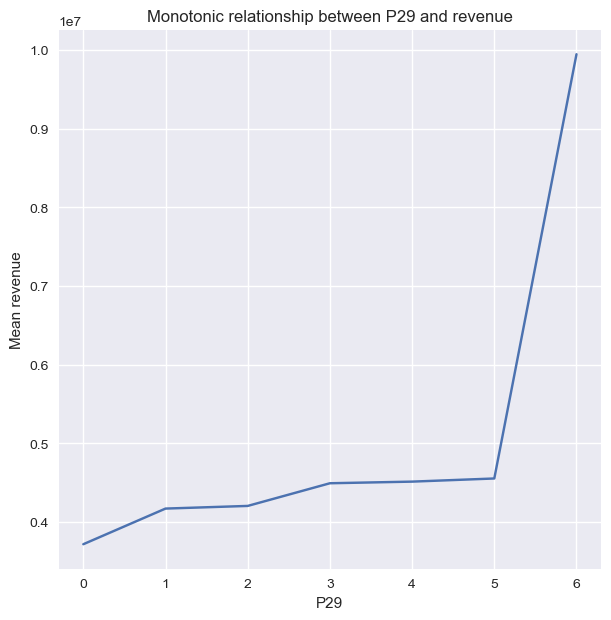

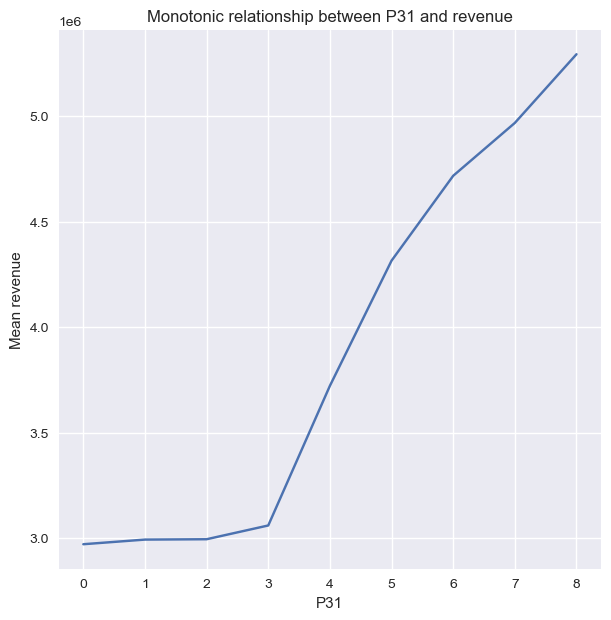

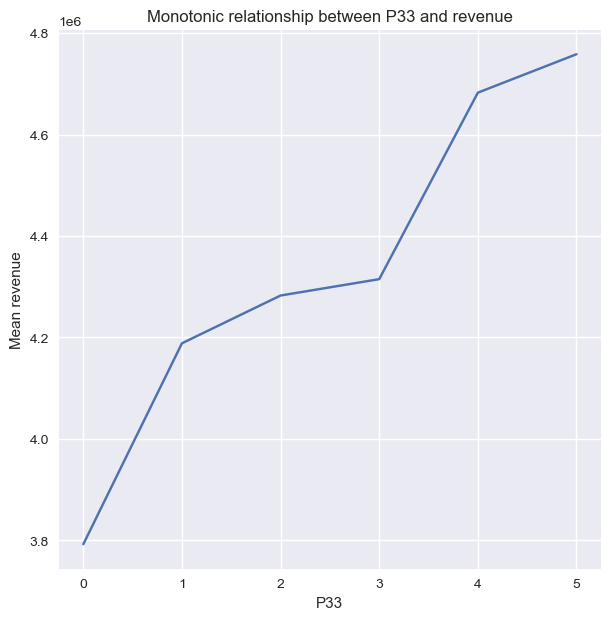

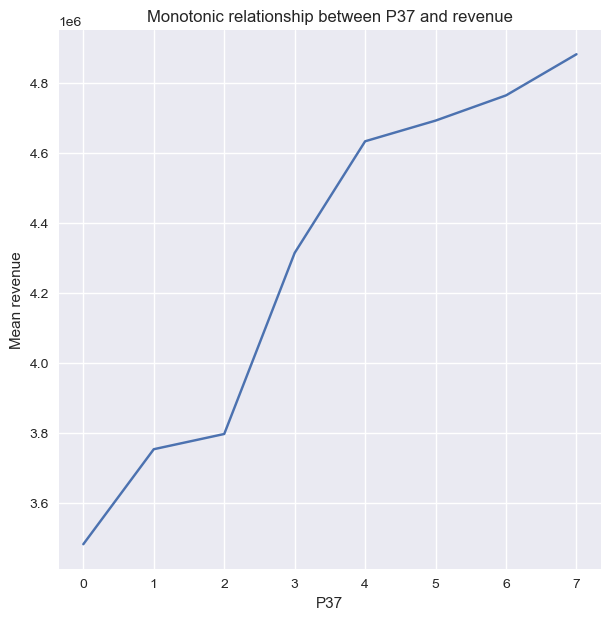

In [38]:
for col in cat_features:    
    fig = plt.figure(figsize=(7,7))
    fig = X_train_selected.groupby([col])['revenue'].mean().plot()
    fig.set_title(f'Monotonic relationship between {col} and revenue')
    fig.set_ylabel('Mean revenue')
    plt.show()

The relationship between the categories and the target is now monotonic, which should help to improve linear models performance. 

In [39]:
# Check X_test after features encoding
X_test_selected.loc[:, X_test_selected.isna().any()].head(3)

,City,P3,P5,P20,P21,P31
0,27.0,3.0,5.0,5.0,0.0,2.0
1,6.0,3.0,3.0,6.0,0.0,5.0
2,21.0,6.0,5.0,0.0,0.0,5.0


There are some new categories in test data. I'll fill NaN values with -1 but it's not the best way because the linear model is sensitive to this value. The best way is to add rare categories and encode them with a training set.

In [40]:
X_test_selected.fillna(-1, inplace=True)
df_val_encod.fillna(-1, inplace=True)

In [41]:
y_train = X_train_selected.pop('revenue')
y_test = X_test_selected.pop('revenue')

<AxesSubplot:xlabel='revenue', ylabel='Count'>

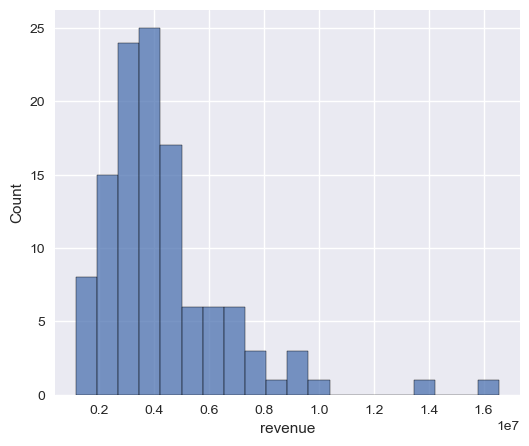

In [42]:
plt.figure(figsize=(6,5))
sns.histplot(data=y_train)

In [43]:
target_scaler = MinMaxScaler(feature_range = (0,1))
target_scaler.fit(y_train.values.reshape(-1, 1))
y_train_scale = target_scaler.transform(y_train.values.reshape(-1, 1))

<AxesSubplot:ylabel='Count'>

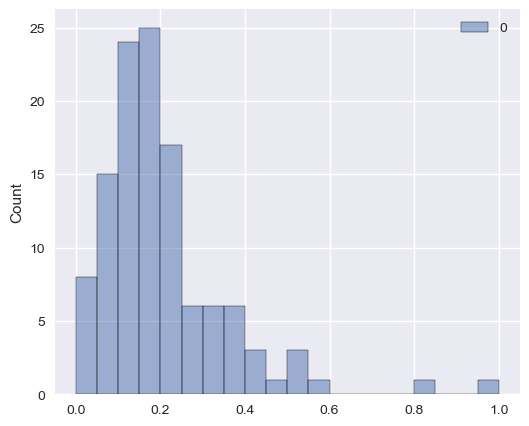

In [44]:
plt.figure(figsize=(6,5))
sns.histplot(data=y_train_scale)

In [45]:
regressor = LinearRegression(fit_intercept = True)
regressor.fit(X_train_selected, y_train_scale)

LinearRegression()

In [46]:
y_predict = regressor.predict(X_test_selected)
y_val_predict = regressor.predict(df_val_encod[X_test_selected.columns])

In [47]:
print(f'RMSE: {mean_squared_error(y_test, target_scaler.inverse_transform(y_predict), squared=False):.2f}')
print(f'R2: {r2_score(y_test, target_scaler.inverse_transform(y_predict)):.4f}')

RMSE: 3652048.75
R2: 0.0425


In [48]:
df_no_corr = df_out.copy()
df_no_corr.insert(1, "Prediction", target_scaler.inverse_transform(y_val_predict), True)
#df_no_corr.to_csv("lin_regression_no_corr.csv", index=False)

In [49]:
df_no_corr.describe()

,Id,Prediction
count,100000.000000,1.000000e+05
mean,49999.500000,4.223027e+06
std,28867.657797,1.386529e+06
min,0.000000,-1.156982e+06
25%,24999.750000,3.274334e+06
50%,49999.500000,4.203527e+06
75%,74999.250000,5.150215e+06
max,99999.000000,9.827611e+06


In [50]:
df_no_corr['Prediction'] = np.where(df_no_corr['Prediction']<0, 0, df_no_corr['Prediction'])
df_no_corr.to_csv("lin_regression_label_encode.csv", index=False)
### 
###Score: 1985413.56674
###Private score: 2083671.58081

In [51]:
metrics = metrics.append({
                            'model': 'LinearRegression',
                            'encoder': 'ordered integer encoding', 
                            'features': X_train_selected.columns.to_list(),
                            'test rmse': mean_squared_error(y_test, target_scaler.inverse_transform(y_predict), squared=False),
                            'test r2': r2_score(y_test, target_scaler.inverse_transform(y_predict)),
                            'private score': 2083671.58081,
                            'public score': 1985413.56674,
                         },
                        ignore_index=True
                        )

C:\Users\Me\AppData\Local\Temp\ipykernel_23004\3855218041.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


### 4.2 Sequential feature selection

http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

In [52]:
target_scaler = MinMaxScaler(feature_range = (0,1))
target_scaler.fit(y_train.values.reshape(-1, 1))
y_train_scale = target_scaler.transform(y_train.values.reshape(-1, 1))

In [53]:
sfs = SFS(LinearRegression(),
          k_features=2,
          forward=False,
          verbose=0,
          scoring='neg_mean_squared_error',
          cv=20)

sfs = sfs.fit(np.array(X_train_selected), y_train_scale)
df_k = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [54]:
df_k.sort_values('avg_score', ascending=False)[:5]

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
8,"(0, 5, 8, 12, 16, 23, 24, 26)","[-0.012409626535589685, -0.008420092216619346,...",-0.014449,"(0, 5, 8, 12, 16, 23, 24, 26)",0.007439,0.015544,0.003566
9,"(0, 5, 8, 12, 13, 16, 23, 24, 26)","[-0.01103125781689186, -0.007691713466234806, ...",-0.014498,"(0, 5, 8, 12, 13, 16, 23, 24, 26)",0.007723,0.016137,0.003702
10,"(0, 2, 5, 8, 12, 13, 16, 23, 24, 26)","[-0.013677388133712534, -0.007121527453132075,...",-0.014557,"(0, 2, 5, 8, 12, 13, 16, 23, 24, 26)",0.007508,0.015689,0.003599
11,"(0, 2, 5, 8, 12, 13, 16, 20, 23, 24, 26)","[-0.012368842597664168, -0.006912492761342805,...",-0.014581,"(0, 2, 5, 8, 12, 13, 16, 20, 23, 24, 26)",0.007454,0.015576,0.003573
7,"(0, 5, 8, 12, 16, 23, 26)","[-0.013075655402009582, -0.006367929527812378,...",-0.014583,"(0, 5, 8, 12, 16, 23, 26)",0.007447,0.015561,0.00357


In [55]:
f_indexes = list(df_k.sort_values('avg_score', ascending=False).iloc[0, 0])
columns_selected = list(X_train_selected.columns[f_indexes])
print('Selected columns:')
print(columns_selected)

Selected columns:
['City', 'P3', 'P6', 'P14', 'P21', 'P31', 'P33', 'open_days']


In [56]:
regressor = LinearRegression(fit_intercept = True)
regressor.fit(X_train_selected[columns_selected], y_train_scale)

LinearRegression()

In [57]:
y_predict = regressor.predict(X_test_selected[columns_selected])
y_val_predict = regressor.predict(df_val_encod[columns_selected])

print(f'RMSE: {mean_squared_error(y_test, target_scaler.inverse_transform(y_predict), squared=False):.2f}')
print(f'R2: {r2_score(y_test, target_scaler.inverse_transform(y_predict)):.4f}')

RMSE: 3600107.28
R2: 0.0696


In [58]:
df_no_corr = df_out.copy()
df_no_corr.insert(1, "Prediction", target_scaler.inverse_transform(y_val_predict), True)
#df_no_corr.to_csv("lin_regression_no_corr.csv", index=False)

In [59]:
df_no_corr.describe()

,Id,Prediction
count,100000.000000,1.000000e+05
mean,49999.500000,4.121535e+06
std,28867.657797,1.424745e+06
min,0.000000,-1.329854e+06
25%,24999.750000,3.144670e+06
50%,49999.500000,4.122944e+06
75%,74999.250000,5.130137e+06
max,99999.000000,9.818951e+06


In [60]:
df_no_corr[df_no_corr.Prediction < 0]['Prediction'] = 0

In [61]:
df_no_corr['Prediction'] = np.where(df_no_corr['Prediction']<0, 0, df_no_corr['Prediction'])
df_no_corr.to_csv("lin_regression_label_encode_selected.csv", index=False)
#####
### Score: 2131788.74924
### Private score: 2183281.28971

In [62]:
metrics = metrics.append({
                            'model': 'LinearRegression',
                            'encoder': 'ordered integer encoding + fs', 
                            'features': columns_selected,
                            'test rmse': mean_squared_error(y_test, target_scaler.inverse_transform(y_predict), squared=False),
                            'test r2': r2_score(y_test, target_scaler.inverse_transform(y_predict)),
                            'private score': 2183281.28971,
                            'public score': 2131788.74924,
                         },
                        ignore_index=True
                        )

C:\Users\Me\AppData\Local\Temp\ipykernel_23004\3045057587.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


In [63]:
metrics

,model,encoder,features,test rmse,test r2,private score,public score
0,LinearRegression,no preproc,P1 - P37,5.511195e+06,-1.180471,2.890660e+06,2.938337e+06
1,LinearRegression,no corr features,"[P1, P2, P3, P4, P5, P6, P7, P8, P11, P14, P17...",4.210302e+06,-0.272581,2.460887e+06,2.206472e+06
2,LinearRegression,ordered integer encoding,"[City, City Group, Type, P1, P2, P3, P4, P5, P...",3.652049e+06,0.042515,2.083672e+06,1.985414e+06
3,LinearRegression,ordered integer encoding + fs,"[City, P3, P6, P14, P21, P31, P33, open_days]",3.600107e+06,0.069557,2.183281e+06,2.131789e+06


###  5. Mean Encoding

### Mean encoding with pandas


### Advantages

- quick
- returns pandas dataframe

### Limitations of pandas:

- it does not preserve information from train data to propagate to test data

We need to store the mappings separately if planning to use the model in production.

In [64]:
X_train_selected = X_train.drop(labels=corr_features, axis=1)
X_test_selected = X_test.drop(labels=corr_features, axis=1)
df_val_encod = df_val.copy()

X_train_selected.shape, X_test_selected.shape

((117, 28), (20, 28))

In [65]:
target_scaler = MinMaxScaler(feature_range = (0,1))
target_scaler.fit(np.array(X_train_selected.revenue).reshape(-1, 1))
y_train_scale = target_scaler.transform(np.array(X_train_selected.revenue).reshape(-1, 1))

In [66]:
X_train_selected.revenue = target_scaler.transform(np.array(X_train_selected.revenue).reshape(-1, 1))

In [67]:
cat_features = ['City', 'City Group', 'Type', 
                'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P11', 'P14', 'P17', 'P19', 
                'P20', 'P21', 'P22', 'P23', 'P24', 'P27', 'P28', 'P29', 'P31', 'P33', 'P37']

In [68]:
def find_category_mappings(df, variable, target):
    return df.groupby([variable])[target].mean().to_dict()

def integer_encode(train, test, val, variable, ordinal_mapping):
    train[variable] = train[variable].map(ordinal_mapping)
    test[variable] = test[variable].map(ordinal_mapping)
    val[variable] = val[variable].map(ordinal_mapping)

In [69]:
# and now we run a loop over the remaining categorical variables
for variable in cat_features:
    mappings = find_category_mappings(X_train_selected, variable, 'revenue')
    integer_encode(X_train_selected, X_test_selected, df_val_encod, variable, mappings)

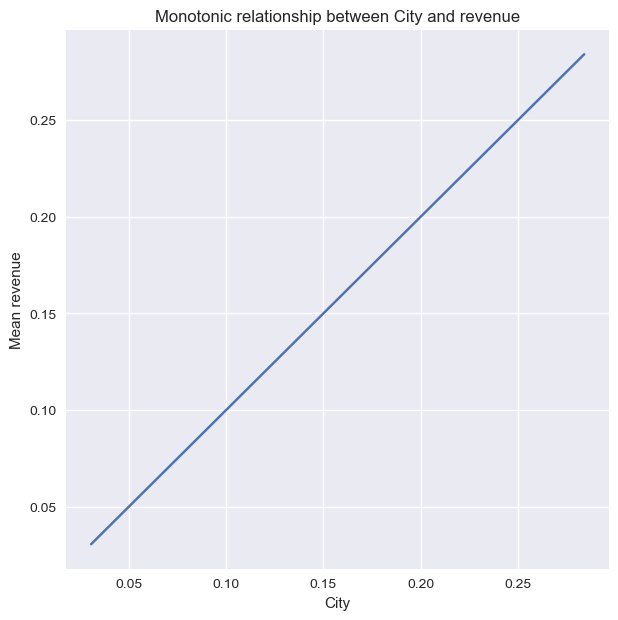

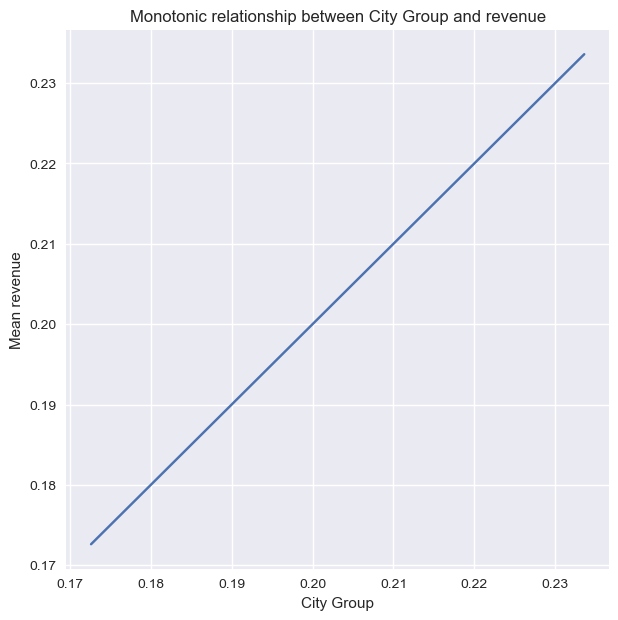

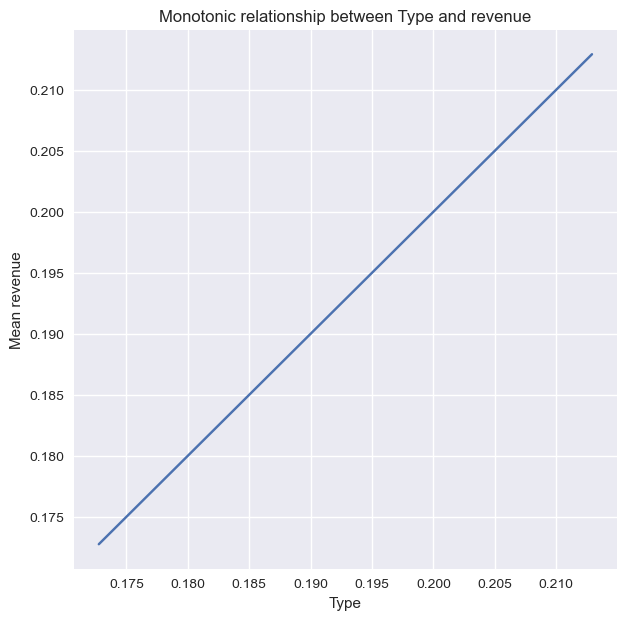

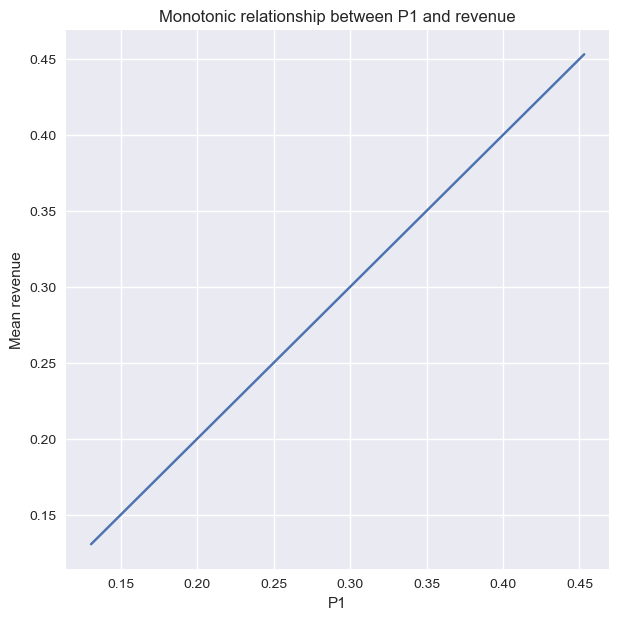

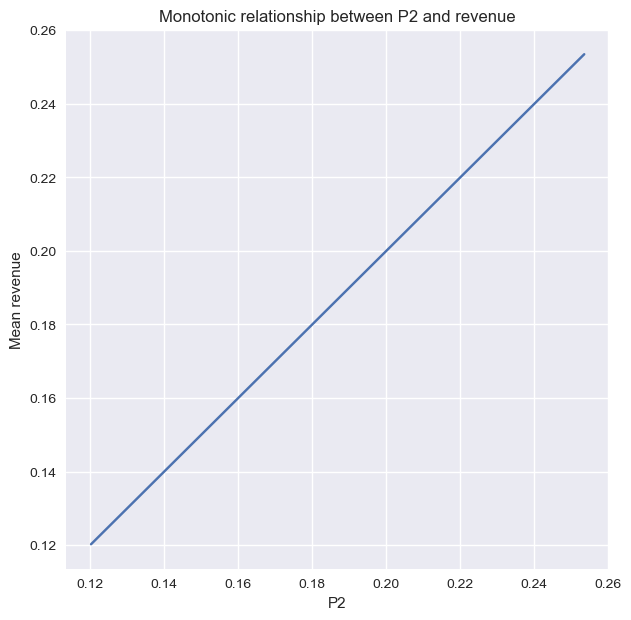

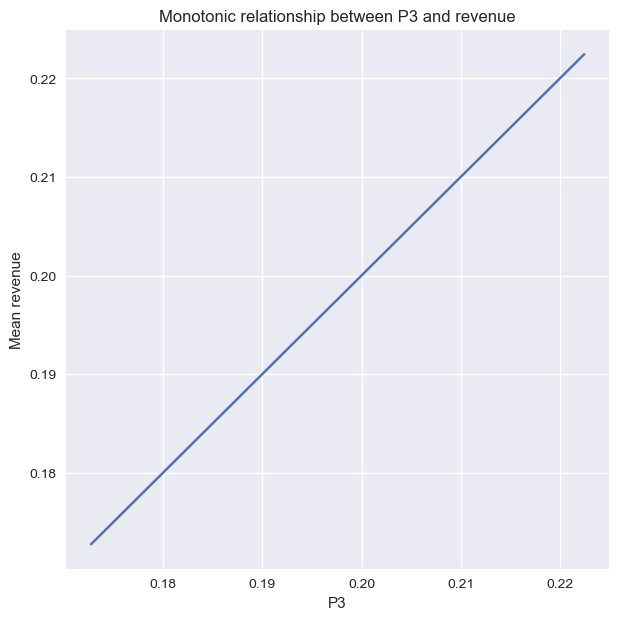

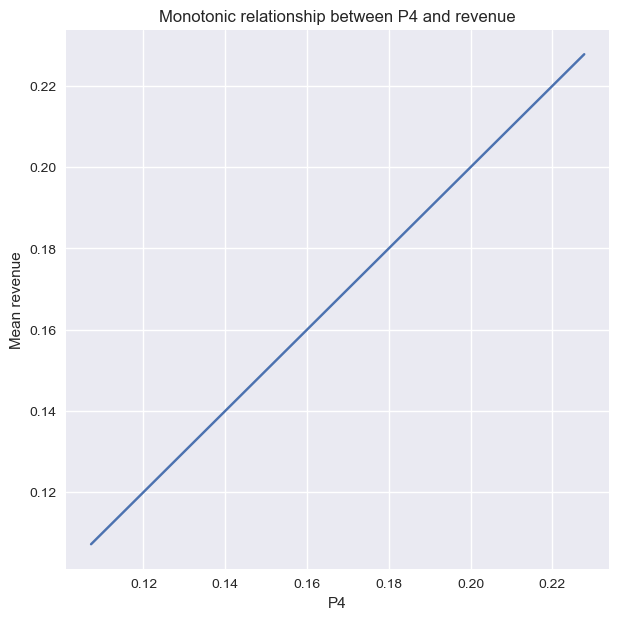

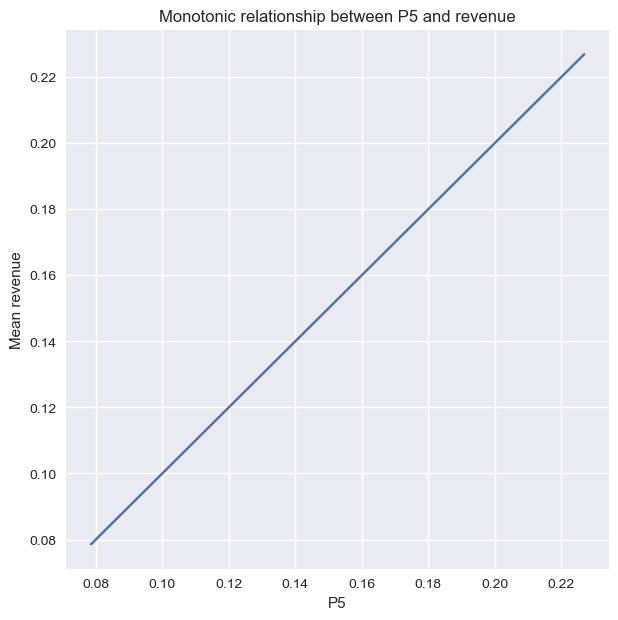

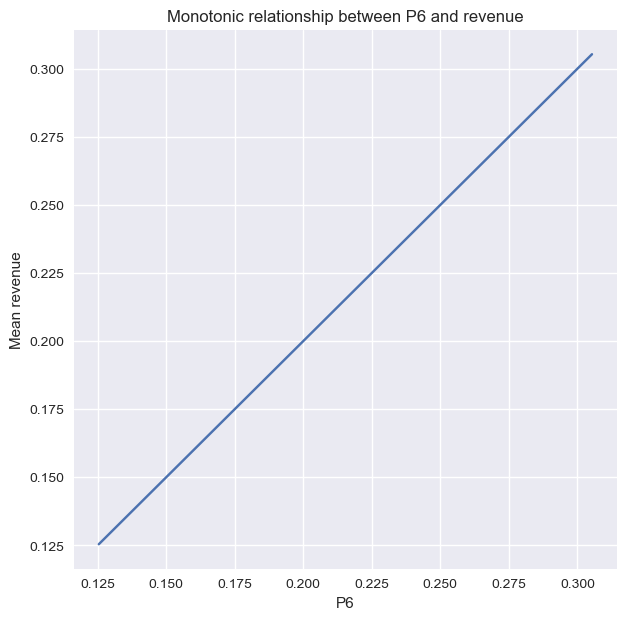

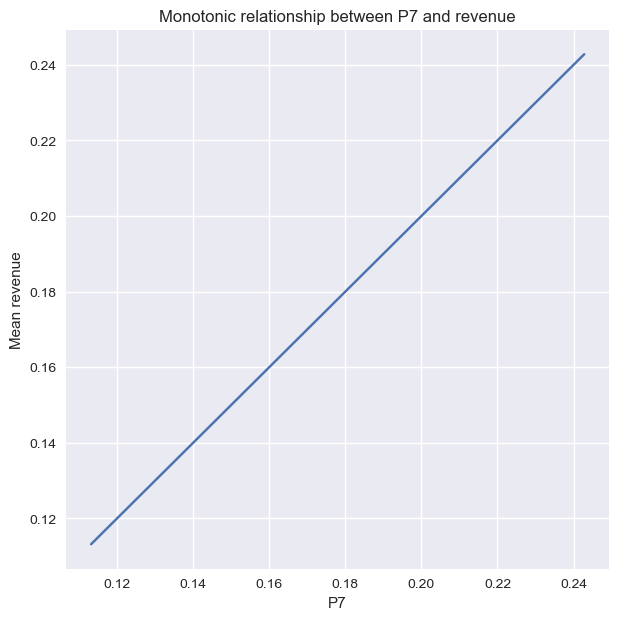

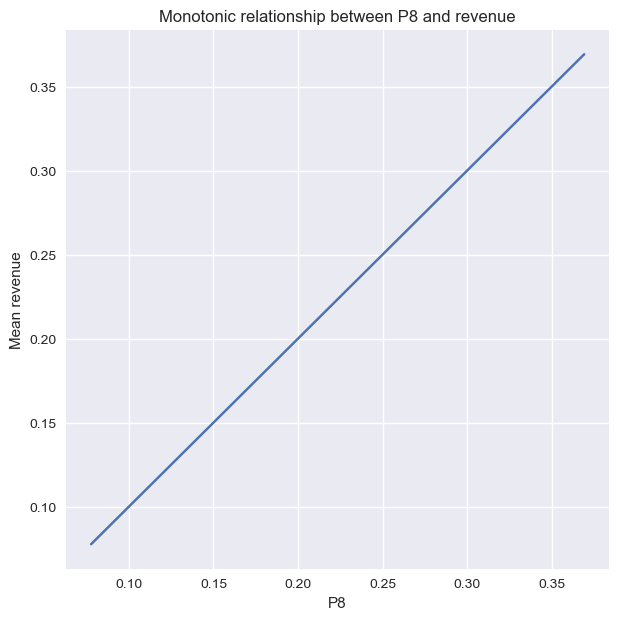

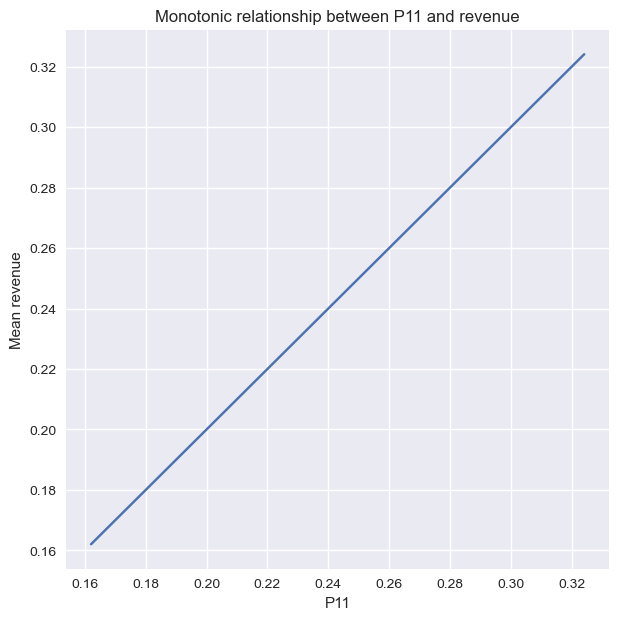

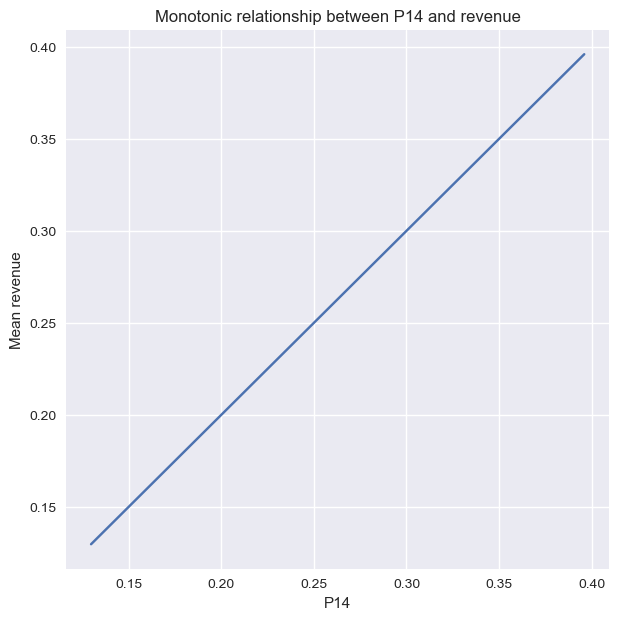

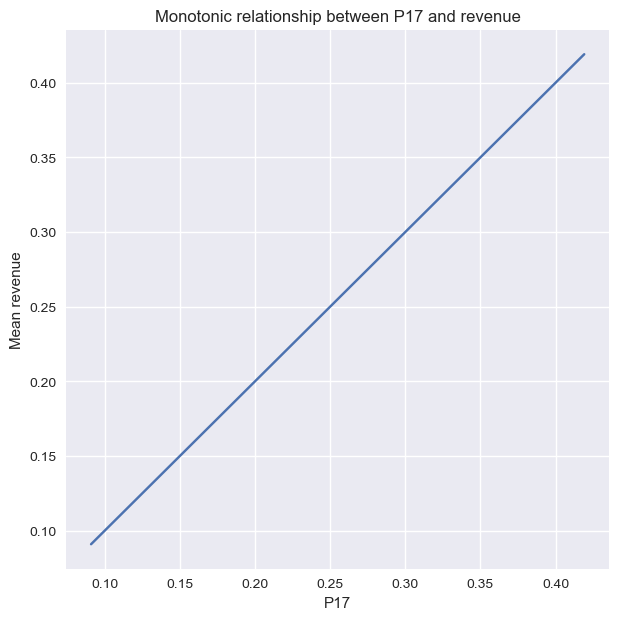

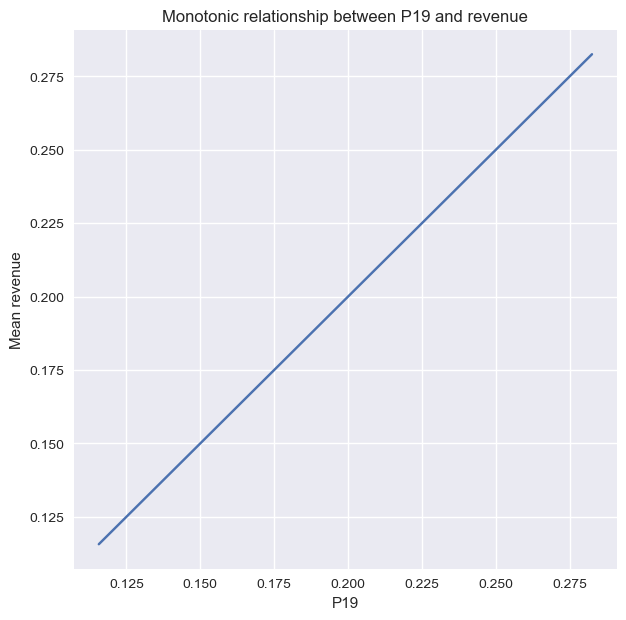

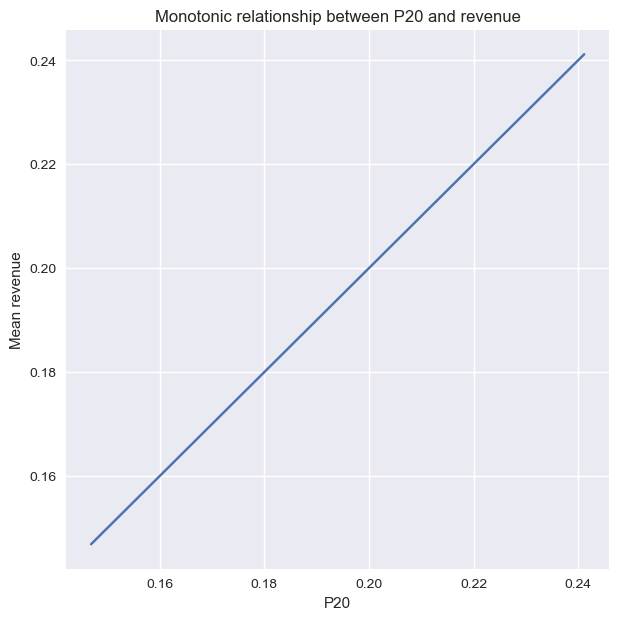

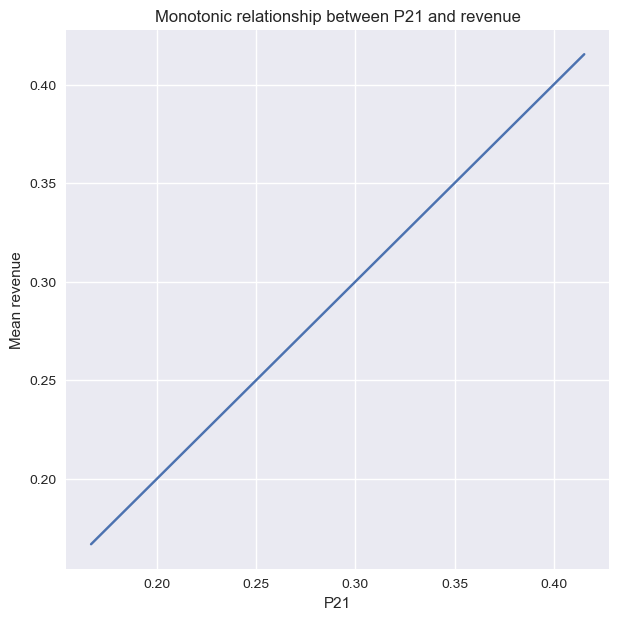

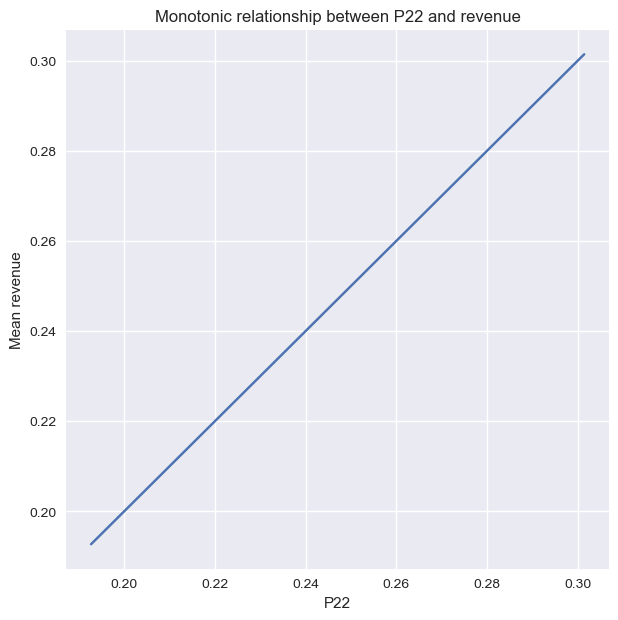

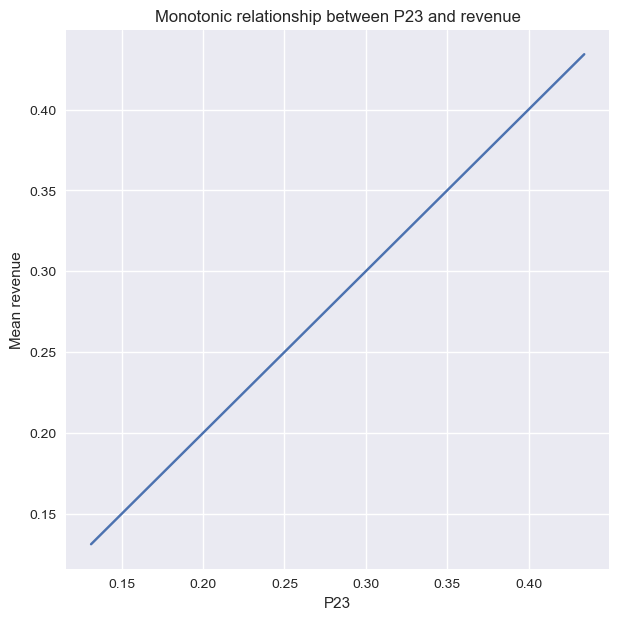

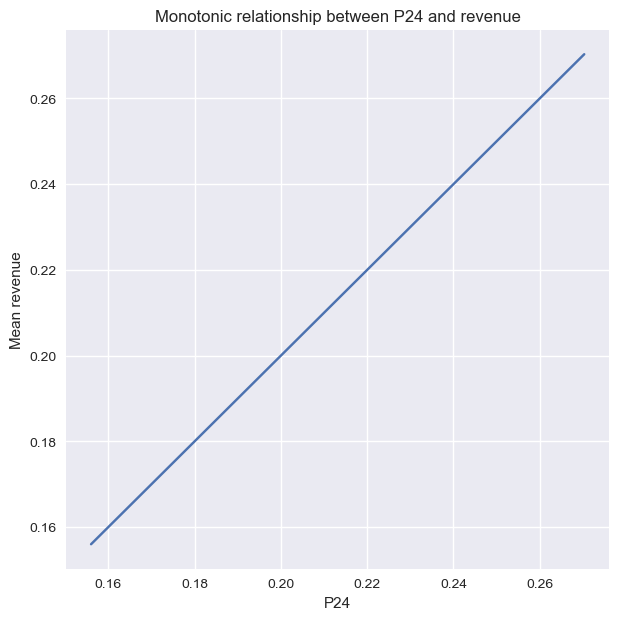

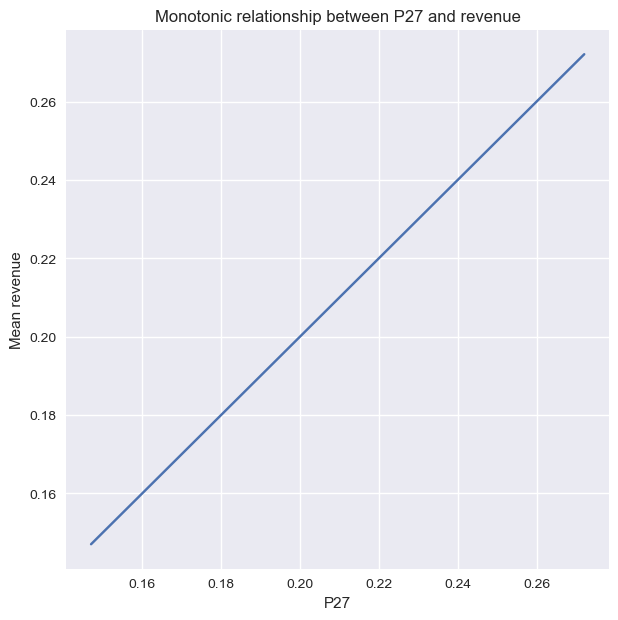

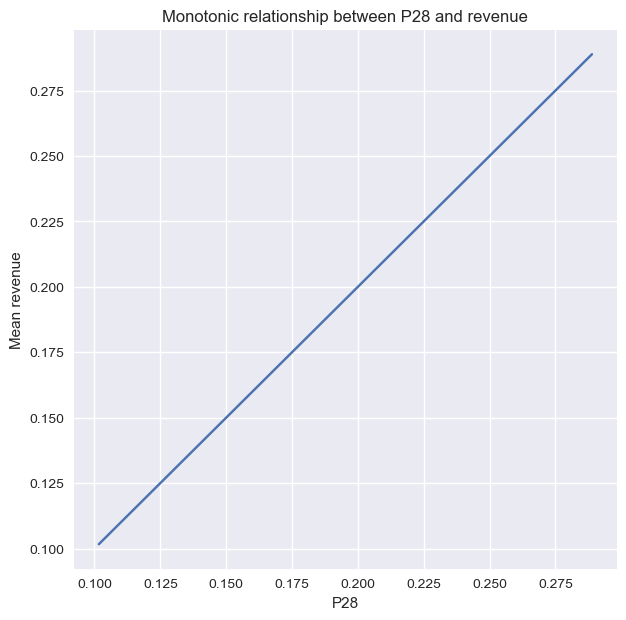

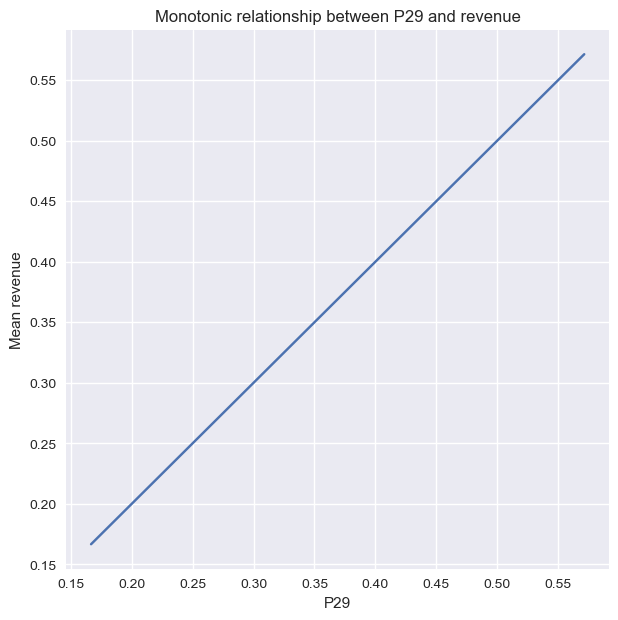

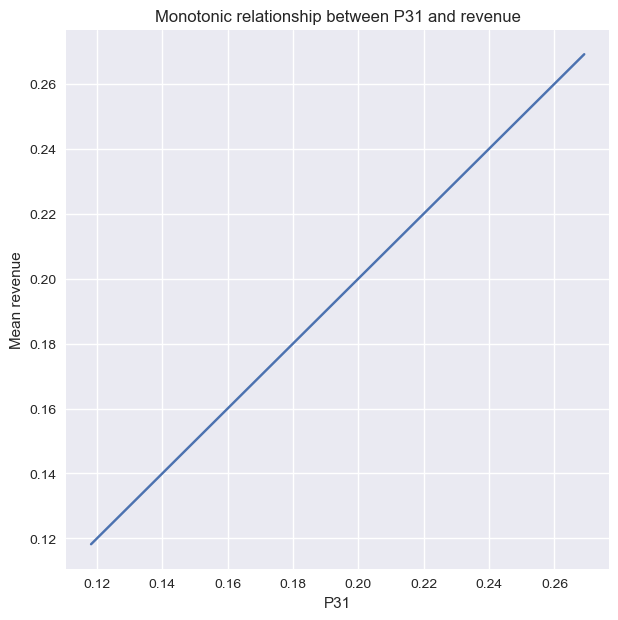

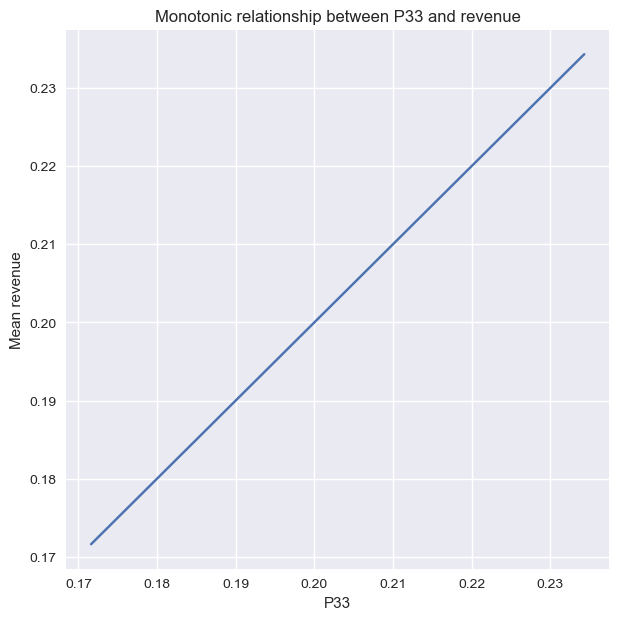

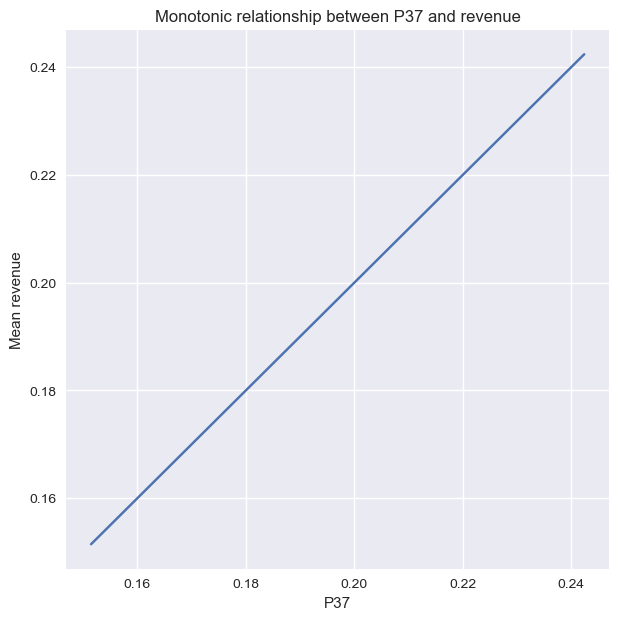

In [70]:
for col in cat_features:    
    fig = plt.figure(figsize=(7,7))
    fig = X_train_selected.groupby([col])['revenue'].mean().plot()
    fig.set_title(f'Monotonic relationship between {col} and revenue')
    fig.set_ylabel('Mean revenue')
    plt.show()

In [71]:
# Check X_test after features encoding
X_test_selected.loc[:, X_test_selected.isna().any()].head(3)

,City,P3,P5,P20,P21,P31
0,0.269318,0.209557,0.226901,0.227366,0.166763,0.119743
1,0.122408,0.209557,0.197886,0.232498,0.166763,0.205539
2,0.222445,0.222445,0.226901,0.146867,0.166763,0.205539


In [72]:
X_test_selected.fillna(-0.01, inplace=True)
df_val_encod.fillna(-0.01, inplace=True)

In [73]:
y_train = X_train_selected.pop('revenue')
y_test = X_test_selected.pop('revenue')

In [74]:
regressor = LinearRegression(fit_intercept = True)
regressor.fit(X_train_selected, y_train)

LinearRegression()

In [75]:
y_predict = regressor.predict(X_test_selected).reshape(-1,1)
y_val_predict = regressor.predict(df_val_encod[X_test_selected.columns]).reshape(-1,1)

In [76]:
print(f'RMSE: {mean_squared_error(y_test, target_scaler.inverse_transform(y_predict), squared=False):.2f}')
print(f'R2: {r2_score(y_test, target_scaler.inverse_transform(y_predict)):.4f}')

RMSE: 3996476.52
R2: -0.1466


In [77]:
df_mean_encode_out = df_out.copy()
df_mean_encode_out.insert(1, "Prediction", target_scaler.inverse_transform(y_val_predict), True)
#df_no_corr.to_csv("lin_regression_no_corr.csv", index=False)

In [78]:
df_no_corr.describe()

,Id,Prediction
count,100000.000000,1.000000e+05
mean,49999.500000,4.122353e+06
std,28867.657797,1.422200e+06
min,0.000000,0.000000e+00
25%,24999.750000,3.144670e+06
50%,49999.500000,4.122944e+06
75%,74999.250000,5.130137e+06
max,99999.000000,9.818951e+06


In [79]:
df_no_corr['Prediction'] = np.where(df_no_corr['Prediction']<0, 0, df_no_corr['Prediction'])
df_no_corr.to_csv("lin_regression_label_encode_selected.csv", index=False)
#####
### Score: 2131788.74924
### Private score: 2183281.28971

In [80]:
metrics = metrics.append({
                            'model': 'LinearRegression',
                            'encoder': 'mean encoding', 
                            'features': X_test_selected.columns.to_list(),
                            'test rmse': mean_squared_error(y_test, target_scaler.inverse_transform(y_predict), squared=False),
                            'test r2': r2_score(y_test, target_scaler.inverse_transform(y_predict)),
                            'private score': 2183281.28971,
                            'public score': 2131788.74924,
                         },
                        ignore_index=True
                        )

C:\Users\Me\AppData\Local\Temp\ipykernel_23004\646539140.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


In [81]:
###

In [ ]:
sfs = SFS(LinearRegression(),
          k_features=2,
          forward=False,
          verbose=0,
          scoring='neg_mean_squared_error',
          cv=20)

sfs = sfs.fit(np.array(X_train_selected), y_train)
df_k = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [ ]:
df_k.sort_values('avg_score', ascending=False)[:5]

In [ ]:
f_indexes = list(df_k.sort_values('avg_score', ascending=False).iloc[0, 0])
columns_selected = list(X_train_selected.columns[f_indexes])
print('Selected columns:')
print(columns_selected)

In [ ]:
regressor = LinearRegression(fit_intercept = True)
regressor.fit(X_train_selected[columns_selected], y_train)

In [ ]:
y_predict = regressor.predict(X_test_selected[columns_selected]).reshape(-1,1)

print(f'RMSE: {mean_squared_error(y_test, target_scaler.inverse_transform(y_predict), squared=False):.2f}')
print(f'R2: {r2_score(y_test, target_scaler.inverse_transform(y_predict)):.4f}')

In [ ]:
y_val_predict = regressor.predict(df_val_encod[columns_selected])
df_no_corr = df_out.copy()
df_no_corr.insert(1, "Prediction", target_scaler.inverse_transform(y_val_predict.reshape(-1,1)), True)
#df_no_corr.to_csv("lin_regression_no_corr.csv", index=False)

df_no_corr.describe()

In [ ]:
#df_no_corr[df_no_corr.Prediction < 0]['Prediction'] = 0

df_no_corr['Prediction'] = np.where(df_no_corr['Prediction']<0, 0, df_no_corr['Prediction'])
df_no_corr.to_csv("lin_regression_mean.csv", index=False)
####
##Score: 2265715.45540
##Private score: 2271094.18920

In [ ]:
metrics = metrics.append({
                            'model': 'LinearRegression',
                            'encoder': 'mean encoding + fs', 
                            'features': columns_selected,
                            'test rmse': mean_squared_error(y_test, target_scaler.inverse_transform(y_predict), squared=False),
                            'test r2': r2_score(y_test, target_scaler.inverse_transform(y_predict)),
                            'private score': 2183281.28971,
                            'public score': 2131788.74924,
                         },
                        ignore_index=True
                        )

In [ ]:
metrics